# End-to-End Algo Trading Pipeline (Single Notebook)

This notebook runs the entire workflow **without executing any bash scripts**:
1. Load raw anonymized per-asset OHLCV CSVs (`Asset_000..Asset_100`)
2. Clean + build a tradeable universe
3. Feature engineering + targets
4. Strategy modeling (Logic Sieve + RandomForest meta-labeling) with walk-forward
5. Backtesting + metrics + plots
6. Statistical arbitrage overlay exploration

Expected input folder: `data/raw/anonymized_data/Asset_###.csv`

In [205]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)
np.random.seed(42)

In [206]:
import importlib
from at.utils.paths import get_paths
import at.data.cleaning as cleaning
importlib.reload(cleaning)
CleaningConfig = cleaning.CleaningConfig
clean_anonymized_assets_folder = cleaning.clean_anonymized_assets_folder

import at.backtest.simulator as simulator
importlib.reload(simulator)
backtest_equal_weight = simulator.backtest_equal_weight
BacktestConfig = simulator.BacktestConfig

from at.features.build import build_feature_frame

from at.backtest.metrics import annualized_sharpe, max_drawdown
from at.viz.plots import plot_equity_curve, plot_underwater, plot_monthly_heatmap

from at.statsarb.pairs import top_correlated_pairs, cointegration_scan

In [207]:
paths = get_paths()
asset_dir = paths.data_raw / 'anonymized_data'
asset_dir

PosixPath('/home/manan/codes/precog/algorithmic-trading/data/raw/anonymized_data')

## 1) Load + clean each asset individually

This applies your Phase I cleaning rules per-asset and then concatenates the universe.

In [208]:
import re

asset_files = sorted(asset_dir.glob('Asset_*.csv'))
asset_ids = []
for p in asset_files:
    m = re.match(r'^Asset_(\d+)\.csv$', p.name)
    if m:
        asset_ids.append(int(m.group(1)))
asset_ids = sorted(asset_ids)

print(f'Found {len(asset_ids)} asset CSVs in {asset_dir}')
if asset_ids:
    print('Asset id range:', min(asset_ids), '->', max(asset_ids))
    print('Example ids:', asset_ids[:5], '...', asset_ids[-5:])

MAX_ASSETS = None
if MAX_ASSETS is not None:
    asset_ids = asset_ids[:MAX_ASSETS]
    print('Capped to first MAX_ASSETS:', MAX_ASSETS)

clean_cfg = CleaningConfig(
    max_missing_frac_per_ticker=0.20,
    fat_finger_return_clip=0.50,
    fat_finger_rolling_mean_window=5,
    min_price=5.0,
    min_dollar_volume=500_000.0,
    hampel_drop_anomalies=True,
    hampel_window_size=20,
    hampel_n_sigmas=3.0,
    hampel_downward_only=True, # Remove only crash-like dips
 )

df_clean, schema = clean_anonymized_assets_folder(
    asset_dir=asset_dir,
    asset_ids=asset_ids,
    filename_template='Asset_{i:03d}.csv',
    cfg=clean_cfg,
 )

df_clean.shape, df_clean['ticker'].nunique()

Found 100 asset CSVs in /home/manan/codes/precog/algorithmic-trading/data/raw/anonymized_data
Asset id range: 1 -> 100
Example ids: [1, 2, 3, 4, 5] ... [96, 97, 98, 99, 100]


((247199, 10), 100)

In [209]:
import matplotlib.pyplot as plt

from at.data.ingest import load_anonymized_asset_csv

fig_dir = paths.figures
fig_dir.mkdir(parents=True, exist_ok=True)

hampel_window = getattr(clean_cfg, "hampel_window_size", 10)
hampel_n_sigmas = getattr(clean_cfg, "hampel_n_sigmas", 3.0)
hampel_min_sigma_frac = getattr(clean_cfg, "hampel_min_sigma_frac", 0.008)
hampel_downward_only = getattr(clean_cfg, "hampel_downward_only", True)

# Limit plots to save time
MAX_PLOTS = 5
print(f"Generating Hampel anomaly plots (limit={MAX_PLOTS})...")

saved = 0
skipped_missing = 0
for i in asset_ids:
    if saved >= MAX_PLOTS:
        print(f"Reached limit of {MAX_PLOTS} plots. Stopping.")
        break
    
    csv_path = asset_dir / f"Asset_{i:03d}.csv"
    if not csv_path.exists():
        skipped_missing += 1
        continue

    df_i, s_i = load_anonymized_asset_csv(csv_path, ticker=f"Asset_{i:03d}")

    # Use the same pre-cleaning steps as the pipeline (but don't drop Hampel anomalies here)
    df_i = cleaning.forward_fill_small_gaps(df_i, s_i, clean_cfg)
    df_i = cleaning.fat_finger_fix(df_i, s_i, clean_cfg)
    df_i = cleaning.apply_hampel_filter(
        df_i,
        s=s_i,
        column=s_i.close,
        window_size=hampel_window,
        n_sigmas=hampel_n_sigmas,
        min_sigma_frac=hampel_min_sigma_frac,
        downward_only=hampel_downward_only,
    )

    fig, ax = cleaning.plot_hampel_filter_result(
        df_i,
        column=s_i.close,
        date_col=s_i.date,
        title=f"Asset_{i:03d} — Hampel anomalies (W={hampel_window}, n_sigmas={hampel_n_sigmas}, DownOnly={hampel_downward_only})",
    )
    out_path = fig_dir / f"hampel_asset_{i:03d}.png"
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    saved += 1

    if saved % 10 == 0:
        print(f"Saved {saved} plots...")

print(f"Saved plots: {saved} -> {fig_dir}")
if skipped_missing:
    print(f"Skipped missing CSVs: {skipped_missing}")


Generating Hampel anomaly plots (limit=5)...
Reached limit of 5 plots. Stopping.
Saved plots: 5 -> /home/manan/codes/precog/algorithmic-trading/reports/figures


In [210]:
df_clean.head()

,date,open,high,low,close,volume,ticker,rolling_median,outlier_score,is_anomaly
0,2016-01-25,29.178415,29.181290,28.514486,28.580592,249449990,Asset_001,28.580592,0.000000,False
1,2016-01-26,28.721415,28.994458,28.186822,28.738659,361581962,Asset_001,28.659626,0.275765,False
2,2016-01-28,26.956690,27.166502,26.554308,27.042913,268157355,Asset_001,27.811753,1.223238,False
3,2016-01-29,27.244108,27.977016,27.117645,27.977016,310239413,Asset_001,27.977016,0.000000,False
4,2016-02-01,27.726962,27.795941,27.419428,27.715465,197189966,Asset_001,27.846241,0.469635,False


## 2) Feature engineering + targets

Outputs a feature frame with a forward-looking target `fwd_ret_1d` (no leakage).

In [211]:
features = build_feature_frame(df_clean, schema)
features.shape

(247199, 19)

## 3) Phase A: Signal Factory (Layer 1) - Directional Predictor

We replace the static logic sieve with a dynamic ML model using **Recursive Expanding Window**.

**Logical Requirements:**
1. **Strict Separation (No Look-Ahead)**: At Month T, train only on Start $\to$ T-1.
2. **Model Independence**: A new model instance is initialized and trained from scratch each month.
3. **Output**: `layer1_prob` (0..1) stored as Out-of-Sample (OOS) predictions.

This creates the **Base Signal** (Bullish/Bearish).


In [212]:
df = features.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "ticker"]).reset_index(drop=True)

Calculating 'Donchian Trend' indicators...
Loaded raw data for Asset_036 (rows=2511)

--- "Donchian Trend" on Asset_036 ---
Total Trades: 33
Win Rate:     51.52%
Strategy Sharpe: 0.7672
Benchmark Sharpe: 0.9753 (Raw Data used)


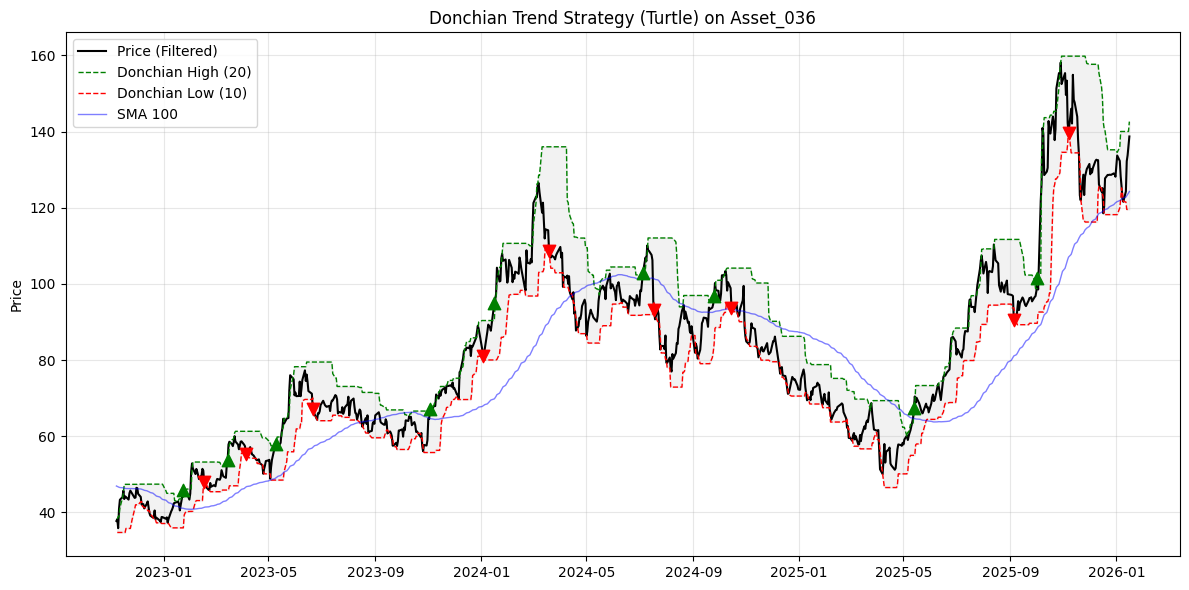

In [213]:
# "Donchian Trend" Strategy Implementation
# Replaces previous "Responsive Swing" logic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from at.data.ingest import load_anonymized_asset_csv

def calc_rsi(series, period=9):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/period, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/period, adjust=False).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

print("Calculating 'Donchian Trend' indicators...")

# Donchian Channels
# 20-day High (Entry basis) and 10-day Low (Exit basis)
# Transform ensures metrics are calculated per-ticker
df['don_high_20'] = df.groupby('ticker')['high'].transform(lambda x: x.rolling(20).max())
df['don_low_10']  = df.groupby('ticker')['low'].transform(lambda x: x.rolling(10).min())

# SMA 100 (Trend Filter)
df['sma_100'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(100).mean())

df['rsi_14'] = df.groupby('ticker')['close'].transform(lambda x: calc_rsi(x, 14))

# Create signal column: 1 = Entry, -1 = Exit
df['don_high_20_lag'] = df.groupby('ticker')['don_high_20'].shift(1)
df['don_low_10_lag']  = df.groupby('ticker')['don_low_10'].shift(1)

df['signal'] = 0

# Entry: Close > Yesterday's 20-Day High AND Close > SMA 100
entry_condition =  (df['close'] > df['sma_100']) & (df['close'] > df['don_high_20_lag'])
df.loc[entry_condition, 'signal'] = 1

# Exit: Close < Yesterday's 10-Day Low
exit_condition = (df['close'] < df['don_low_10_lag'])
df.loc[exit_condition, 'signal'] = -1

df['signal_turtle_entry'] = (df['signal'] == 1).astype(int)
df['signal_a'] = df['signal_turtle_entry']

sample_ticker = df['ticker'].value_counts().idxmax() 
sdf = df[df['ticker'] == sample_ticker].copy().sort_values('date').reset_index(drop=True)

# --- LOAD RAW DATA FOR BENCHMARK ---
raw_path = asset_dir / f"{sample_ticker}.csv"
if raw_path.exists():
    raw_sdf, _ = load_anonymized_asset_csv(raw_path, ticker=sample_ticker)
    raw_sdf = raw_sdf.sort_values('date').reset_index(drop=True)
    print(f"Loaded raw data for {sample_ticker} (rows={len(raw_sdf)})")
else:
    print(f"Warning: Raw file not found for {sample_ticker}, using filtered data.")
    raw_sdf = sdf.copy()
# -----------------------------------

print(f"\n--- \"Donchian Trend\" on {sample_ticker} ---")

trades_log = []
pos_type = 0  # 0=Flat, 1=Long
entry_px = 0.0
entry_idx = 0

for i in range(21, len(sdf)): # Start after ramp-up
    curr_row = sdf.iloc[i]
    prev_row = sdf.iloc[i-1]
    
    # Pre-calc decision thresholds from Yesterday
    don_breakout_level = sdf.at[i-1, 'don_high_20']
    don_exit_level     = sdf.at[i-1, 'don_low_10']
    sma_filter         = curr_row['sma_100']

    # --- 1. HANDLE EXITS ---
    if pos_type == 1:
        # Exit Rule: Close < Donchian Low (10) of previous days
        if curr_row['close'] < don_exit_level:
            exit_px = curr_row['close']
            pnl = exit_px - entry_px
            hold_days = (curr_row['date'] - sdf.at[entry_idx, 'date']).days
            
            trades_log.append({
                'Entry Date': sdf.at[entry_idx, 'date'],
                'Type': 'Long',
                'Entry Price': entry_px,
                'Exit Date': curr_row['date'],
                'Exit Price': exit_px,
                'Reason': 'Donchian_Low_Break',
                'PnL': pnl,
                'HoldDays': hold_days
            })
            pos_type = 0
            continue

    # --- 2. HANDLE ENTRIES ---
    if pos_type == 0:
        # # Entry Rule: Close > Donchian High (20) AND Close > SMA 100
        if (curr_row['close'] > don_breakout_level) and (curr_row['close'] > sma_filter):
            pos_type = 1
            entry_px = curr_row['close']
            entry_idx = i

# --- Reporting ---
trades_df = pd.DataFrame(trades_log)

# Calculate Benchmark Stats (Buy & Hold) for THIS ticker
if not trades_df.empty:
    start_date = trades_df['Entry Date'].min()
    end_date = sdf['date'].max()
    
    # --- BENCHMARK ON RAW DATA ---
    mask_bh = (raw_sdf['date'] >= start_date) & (raw_sdf['date'] <= end_date)
    bh_df = raw_sdf.loc[mask_bh].copy()
    
    # Benchmark PnL (Absolute price diff)
    if not bh_df.empty:
        bench_ret_abs = bh_df.iloc[-1]['close'] - bh_df.iloc[0]['close']
        
        # Benchmark Sharpe
        bh_df['daily_ret'] = bh_df['close'].pct_change()
        bench_sharpe = (bh_df['daily_ret'].mean() / bh_df['daily_ret'].std()) * np.sqrt(252)
    else:
        bench_ret_abs = 0.0
        bench_sharpe = 0.0
    # -----------------------------
   
    # Strategy Sharpe 
    sdf['daily_ret'] = sdf['close'].pct_change()
    sdf['strat_ret'] = 0.0
    
    # Mark Long Days
    long_mask = pd.Series(0, index=sdf.index)
    for idx, row in trades_df.iterrows():
        # Find start and end indices in sdf
        e_date = row['Entry Date']
        x_date = row['Exit Date']
        mask = (sdf['date'] > e_date) & (sdf['date'] <= x_date)
        sdf.loc[mask, 'strat_ret'] = sdf.loc[mask, 'daily_ret']
        
    strat_sharpe = (sdf['strat_ret'].mean() / sdf['strat_ret'].std()) * np.sqrt(252)
    
    total_trades = len(trades_df)
    win_rate = (trades_df['PnL'] > 0).sum() / total_trades
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate:     {win_rate:.2%}")
    print(f"Strategy Sharpe: {strat_sharpe:.4f}")
    print(f"Benchmark Sharpe: {bench_sharpe:.4f} (Raw Data used)")
    
else:
    print("No trades generated.")


# --- Plotting ---
plot_days = 800
p_df = sdf.iloc[-plot_days:].copy()

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
ax = axes

# Price
ax.plot(p_df['date'], p_df['close'], color='black', linewidth=1.5, label='Price (Filtered)')

# Donchian Channels
# Shift by 1 because the breakout level for Today is determined by Yesterday's window
ax.plot(p_df['date'], p_df['don_high_20'].shift(1), color='green', linewidth=1, linestyle='--', label='Donchian High (20)')
ax.plot(p_df['date'], p_df['don_low_10'].shift(1), color='red', linewidth=1, linestyle='--', label='Donchian Low (10)')
ax.fill_between(p_df['date'], p_df['don_high_20'].shift(1), p_df['don_low_10'].shift(1), color='gray', alpha=0.1)

# SMA 100
ax.plot(p_df['date'], p_df['sma_100'], color='blue', linewidth=1, alpha=0.5, label='SMA 100')

# Trades
for t in trades_log:
    if t['Entry Date'] >= p_df['date'].min():
        ax.scatter(t['Entry Date'], t['Entry Price'], color='green', marker='^', s=80, zorder=5)
    if t['Exit Date'] >= p_df['date'].min():
        ax.scatter(t['Exit Date'], t['Exit Price'], color='red', marker='v', s=80, zorder=5)

ax.set_title(f"Donchian Trend Strategy (Turtle) on {sample_ticker}")
ax.set_ylabel("Price")
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4) Phase B: Meta-Labeling (RandomForest)

We train a **meta-labeler** that learns which Model A signals are likely to win.

Key constraints:
- **Time-ordered splits only** (no shuffle)
- **Purged / embargo gap** between train and test to reduce leakage

In [214]:
# Step 1: Candidate set + meta-features (robust, stationary; no raw prices as features)
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "ticker"]).reset_index(drop=True)

# If needed, compute a forward return target for meta-labeling (1d)
if "fwd_ret_1d" not in df.columns:
    df["fwd_ret_1d"] = df.groupby("ticker")["close"].pct_change(1).shift(-1)

# --- FracDiff Helper Functions ---

def get_weights_fixed(d, size):
    """Generate weights for fixed-width fractional differentiation."""
    w = [1.0]
    for k in range(1, size):
        w_k = -w[-1] / k * (d - k + 1)
        w.append(w_k)
    return np.array(w[::-1])


def get_weights_ffd(d: float, thresh: float = 1e-5) -> np.ndarray:
    """Fixed-Width Fractional Differentiation weights (Lopez de Prado style).

    We expand weights until the next weight magnitude drops below `thresh`.
    """
    w = [1.0]
    k = 1
    while True:
        w_k = -w[-1] / k * (d - k + 1)
        if abs(w_k) < thresh:
            break
        w.append(w_k)
        k += 1
        if k > 10_000:
            break
    return np.array(w[::-1], dtype=float)


def frac_diff_ffd(series: pd.Series, d: float, *, thresh: float = 1e-5) -> pd.Series:
    """Apply fixed-width fractional differentiation to a 1D series."""
    s = pd.to_numeric(series, errors="coerce").astype(float)
    w = get_weights_ffd(float(d), float(thresh))
    width = int(len(w))
    if width <= 0:
        return pd.Series(np.nan, index=s.index)
    return s.rolling(window=width, min_periods=width).apply(lambda x: float(np.dot(w, x)), raw=True)


def plot_min_ffd(
    series: pd.Series,
    *,
    ds: np.ndarray | None = None,
    thresh: float = 1e-5,
    adf_alpha: float = 0.05,
    maxlag: int = 1,
    regression: str = "c",
    autolag=None,
    show_plot: bool = True,
) -> pd.DataFrame:
    """Find the minimum fractional differencing d that passes ADF @ 95% confidence."""

    import matplotlib.pyplot as plt

    s = pd.to_numeric(series, errors="coerce").dropna().astype(float)
    if ds is None:
        ds = np.round(np.arange(0.0, 1.01, 0.02), 2)

    rows = []
    for d in ds:
        try:
            diffed = frac_diff_ffd(s, float(d), thresh=thresh).dropna()
            if len(diffed) < 50:
                continue

            aligned = s.loc[diffed.index]
            if len(aligned) != len(diffed):
                continue

            res = adfuller(diffed.values, maxlag=maxlag, regression=regression, autolag=autolag)
            pval = float(res[1])

            corr = float(np.corrcoef(aligned.values, diffed.values)[0, 1])
            if not np.isfinite(corr):
                corr = np.nan

            rows.append({"d": float(d), "pval": pval, "corr": corr})
        except Exception:
            continue

    out = pd.DataFrame(rows).sort_values("d").reset_index(drop=True)

    if show_plot and not out.empty:
        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(out["d"], out["pval"], marker="o", color="purple", label="ADF p-value")
        ax1.axhline(adf_alpha, color="gray", linestyle="--", linewidth=1.0, label=f"p={adf_alpha:.2f}")
        ax1.set_xlabel("d")
        ax1.set_ylabel("ADF p-value")
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.25)

        ax2 = ax1.twinx()
        ax2.plot(out["d"], out["corr"], marker=".", color="teal", alpha=0.8, label="Corr (memory)")
        ax2.set_ylabel("Correlation(original, frac-diff)")

        passing = out[out["pval"] < adf_alpha]
        if not passing.empty:
            d_star = float(passing["d"].min())
            c_star = float(out.loc[out["d"] == d_star, "corr"].iloc[0])
            plt.title(f"Minimum d passing ADF: {d_star:.2f} (corr={c_star:.2f})")
        else:
            plt.title("No d passed ADF in grid")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
        plt.tight_layout()
        plt.show()

    return out


def get_frac_diff_features(
    df,
    close_col: str = "close",
    group_col: str = "ticker",
    d_default: float | None = None,
    window: int = 100,
    optimize_d: bool = True,
    *,
    d_grid: np.ndarray | None = None,
    adf_alpha: float = 0.05,
    thresh: float = 1e-5,
    max_obs_for_adf: int = 2000,
    fallback_d: float = 1.0,
    verbose: bool = False,
    plot_first_n: int = 0,
):
    """Applies Fixed-Width Fractional Differentiation (FFD) to close price:
    - If `optimize_d=True`, this estimates d per asset by running ADF on a tail slice of the
      *full* series passed in. That is not causal for earlier timestamps.
    """

    out = df.copy()

    if d_grid is None:
        d_grid = np.round(np.arange(0.0, 1.01, 0.02), 2)

    out["frac_diff_close"] = np.nan
    out["ffd_d_close"] = np.nan

    groups = out.groupby(group_col, sort=False)
    if optimize_d:
        print(f"Calculating FracDiff (FFD) per-asset min d via ADF@{int((1-adf_alpha)*100)}%...")
    else:
        d_msg = "fallback" if d_default is None else f"d_default={float(d_default):.2f}"
        print(f"Calculating FracDiff (FFD) with fixed d ({d_msg})...")

    plotted = 0
    chosen_ds = {}

    for gname, idx in groups.groups.items():
        x_full = pd.to_numeric(out.loc[idx, close_col], errors="coerce").astype(float)

        x_tail = x_full.dropna()
        if max_obs_for_adf is not None and max_obs_for_adf > 0:
            x_tail = x_tail.iloc[-int(max_obs_for_adf):]

        if optimize_d and len(x_tail) >= 200:
            show_plot = plotted < int(plot_first_n)
            res_df = plot_min_ffd(
                x_tail,
                ds=d_grid,
                thresh=thresh,
                adf_alpha=adf_alpha,
                maxlag=1,
                regression="c",
                autolag=None,
                show_plot=show_plot,
            )
            if show_plot:
                plotted += 1

            passing = res_df[res_df["pval"] < adf_alpha] if not res_df.empty else pd.DataFrame()
            if not passing.empty:
                d_sel = float(passing["d"].min())
            else:
                d_sel = float(fallback_d)
        else:
            if d_default is None:
                d_sel = float(fallback_d)
            else:
                d_sel = float(d_default)

        chosen_ds[gname] = d_sel
        out.loc[idx, "frac_diff_close"] = frac_diff_ffd(x_full, d_sel, thresh=thresh).values
        out.loc[idx, "ffd_d_close"] = d_sel

        if verbose:
            print(f"{gname}: d={d_sel:.2f} (n={int(x_full.notna().sum())})")

    if len(chosen_ds) > 0:
        d_vals = pd.Series(chosen_ds).astype(float)
        print("Selected d stats:")
        # display(d_vals.describe())

    return out



def add_stationary_features(
    d: pd.DataFrame,
    *,
    close_col: str = "close",
    high_col: str = "high",
    low_col: str = "low",
    open_col: str = "open",
    volume_col: str = "volume",
    group_col: str = "ticker",
    rsi_col: str = "rsi_14",
    bb_window: int = 20,
    sma_fast: int = 50,
    sma_slow: int = 200,
    vol_short: int = 20,
    vol_long: int = 100,
) -> tuple[pd.DataFrame, list[str]]:
    """Add a robust, stationary feature set (no raw prices as features)."""
    out = d.copy()

    # 0) Apply Fractional Differentiation (Stationarity Preserving)
    # NOTE: We disable optimize_d to avoid non-causal tail-optimization leakage.
    FRACDIFF_D = 0.50
    out = get_frac_diff_features(
        out,
        close_col=close_col,
        group_col=group_col,
        optimize_d=True,
        d_default=FRACDIFF_D,
        adf_alpha=0.05,
        thresh=1e-5,
        max_obs_for_adf=2000,
        fallback_d=1.0,
        verbose=False,
        plot_first_n=0,
    )

    g = out.groupby(group_col, sort=False)

    if rsi_col not in out.columns:
        raise KeyError(f"Missing {rsi_col}. Re-run feature engineering so RSI is present.")

    # 1) Log returns (momentum)
    for n in (1, 5, 10, 21):
        out[f"log_ret_{n}d"] = g[close_col].transform(
            lambda x: np.log(x.astype(float).replace(0, np.nan) / x.astype(float).replace(0, np.nan).shift(n))
        )
 

    # Volatility clustering 
    out["ewm_vol_20"] = g["log_ret_1d"].transform(lambda x: x.ewm(span=20, adjust=False).std(bias=False))
    out["_ewm_vol_100"] = g["log_ret_1d"].transform(lambda x: x.ewm(span=100, adjust=False).std(bias=False))
    out["vol_cluster_ratio"] = out["ewm_vol_20"] / out["_ewm_vol_100"].replace(0, np.nan)

    out["vol_of_vol_20"] = g["ewm_vol_20"].transform(lambda x: x.rolling(20, min_periods=20).std(ddof=0))

    out["serial_corr_20"] = g["log_ret_1d"].transform(
        lambda x: x.rolling(20).apply(lambda y: y.autocorr(lag=1), raw=False),
    )

    if {"bid_size", "ask_size"}.issubset(set(out.columns)):
        denom = (out["bid_size"].astype(float) + out["ask_size"].astype(float)).replace(0, np.nan)
        out["order_imbalance"] = (out["bid_size"].astype(float) - out["ask_size"].astype(float)) / denom
    else:
        if {open_col, high_col, low_col}.issubset(set(out.columns)):
            rng = (out[high_col].astype(float) - out[low_col].astype(float)).replace(0, np.nan)
            bar_pressure = (out[close_col].astype(float) - out[open_col].astype(float)) / rng
            bar_pressure = bar_pressure.clip(-1.0, 1.0).fillna(0.0)
            vol_sma20 = g[volume_col].transform(lambda x: x.rolling(20, min_periods=20).mean())
            out["order_imbalance"] = bar_pressure * (out[volume_col].astype(float) / vol_sma20.replace(0, np.nan))
        else:
            out["order_imbalance"] = np.nan

    # Volatility regimes
    out["roll_vol_20d"] = g["log_ret_1d"].transform(lambda x: x.rolling(vol_short, min_periods=vol_short).std(ddof=0))
    out["_roll_vol_100d"] = g["log_ret_1d"].transform(lambda x: x.rolling(vol_long, min_periods=vol_long).std(ddof=0))
    out["vol_ratio"] = out["roll_vol_20d"] / out["_roll_vol_100d"]

    out["vol_regime_ratio"] = g["log_ret_1d"].transform(
        lambda x: x.rolling(21).std(ddof=0) / x.rolling(63).std(ddof=0).replace(0, np.nan),
    )

    # Bollinger Band width
    out["_bb_mid"] = g[close_col].transform(lambda x: x.rolling(bb_window, min_periods=bb_window).mean())
    out["_bb_std"] = g[close_col].transform(lambda x: x.rolling(bb_window, min_periods=bb_window).std(ddof=0))
    out["bb_width"] = (4.0 * out["_bb_std"]) / out["_bb_mid"]

    # Relative strength
    out["_sma_50"] = g[close_col].transform(lambda x: x.rolling(sma_fast, min_periods=sma_fast).mean())
    out["_sma_200"] = g[close_col].transform(lambda x: x.rolling(sma_slow, min_periods=sma_slow).mean())
    out["dist_sma50"] = (out[close_col] / out["_sma_50"]) - 1.0
    out["dist_sma200"] = (out[close_col] / out["_sma_200"]) - 1.0

    # Market Breadth
    out["is_above_sma200"] = (out[close_col] > out["_sma_200"]).astype(float)
    daily_breadth = out.groupby("date")["is_above_sma200"].transform("mean")
    out["market_breadth"] = daily_breadth

    # Volume dynamics
    out["vol_change"] = g[volume_col].transform(
        lambda x: np.log(x.astype(float).replace(0, np.nan) / x.astype(float).replace(0, np.nan).shift(1)),
    )
    out["rel_vol"] = out[volume_col] / g[volume_col].transform(lambda x: x.rolling(20, min_periods=20).mean())

    vol_ma_5 = g[volume_col].transform(lambda x: x.rolling(5).mean())
    vol_ma_20 = g[volume_col].transform(lambda x: x.rolling(20).mean())
    out["volume_oscillator"] = (vol_ma_5 - vol_ma_20) / vol_ma_20.replace(0, np.nan)

    # Time Attributes
    out["day_of_week"] = out["date"].dt.dayofweek  # 0=Mon, 4=Fri
    out["is_friday"] = (out["day_of_week"] == 4).astype(float)

    # Volatility / ATR 
    out["_tr1"] = (out[high_col] - out[low_col]).abs()
    out["_tr2"] = (out[high_col] - out[close_col].shift(1)).abs()
    out["_tr3"] = (out[low_col] - out[close_col].shift(1)).abs()
    out["_tr"] = out[["_tr1", "_tr2", "_tr3"]].max(axis=1)
    out["_atr"] = g["_tr"].transform(lambda x: x.rolling(14).mean())
    out["atr_ratio"] = out["_atr"] / out[close_col]

    if "bid" in out.columns and "ask" in out.columns:
        out["bid_ask_spread"] = (out["ask"] - out["bid"]) / out["ask"]

    out["high_low_range"] = (out[high_col] - out[low_col]) / out[close_col]
    denom = (out[high_col] - out[low_col]).astype(float)
    out["close_loc"] = (out[close_col] - out[low_col]) / denom.replace(0, np.nan)

    out = out.replace([np.inf, -np.inf], np.nan)

    feature_cols = [
        "vol_of_vol_20",
        "market_breadth",
        rsi_col,
        "log_ret_5d",
        "log_ret_10d",
        "log_ret_21d",
        "bb_width",
        "dist_sma50",
        "dist_sma200",
        "atr_ratio",
    ]
    if "bid_ask_spread" in out.columns:
        feature_cols.append("bid_ask_spread")

    feature_cols = [c for c in feature_cols if c in out.columns]
    return out, feature_cols

In [ ]:
import itertools
from math import comb

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# --- Rolling window parameters (override by setting globals before running this cell) ---
DON_ENTRY_WINDOW = int(globals().get("DON_ENTRY_WINDOW", 20))
DON_EXIT_WINDOW = int(globals().get("DON_EXIT_WINDOW", 10))
SMA_WINDOW = int(globals().get("SMA_WINDOW", 100))

DON_HIGH_COL = f"_don_high_{DON_ENTRY_WINDOW}"
DON_LOW_COL = f"_don_low_{DON_EXIT_WINDOW}"
SMA_COL = f"_sma_{SMA_WINDOW}"


def calculate_daily_volatility(df, span=100):
    df["volatility"] = df.groupby("ticker")["close"].transform(
        lambda x: x.pct_change().ewm(span=span).std()
    )
    return df


def _get_continuous_position(entry: np.ndarray, exit: np.ndarray) -> np.ndarray:
    out = np.zeros(len(entry), dtype=int)
    current_pos = 0
    for i in range(len(entry)):
        if current_pos == 1:
            if bool(exit[i]):
                current_pos = 0
        else:
            if bool(entry[i]):
                current_pos = 1
        out[i] = current_pos
    return out


def build_primary_trade_events(
    df: pd.DataFrame,
    min_trade_ret: float = 0.0,
    don_entry_window: int = DON_ENTRY_WINDOW,
    don_exit_window: int = DON_EXIT_WINDOW,
    sma_window: int = SMA_WINDOW,
) -> pd.DataFrame:
    """Primary trade events (per-entry rows).

    - entry: close > shift(1).rolling(don_entry_window).max(high) AND close > sma(sma_window)
    - exit:  close < shift(1).rolling(don_exit_window).min(low)

    Note: Donchian/SMA columns are computed internally using window-based names.
    """

    out = df.copy()
    out["date"] = pd.to_datetime(out["date"])
    out = out.sort_values(["date", "ticker"]).reset_index(drop=True)

    don_high_col = f"_don_high_{int(don_entry_window)}"
    don_low_col = f"_don_low_{int(don_exit_window)}"
    sma_col = f"_sma_{int(sma_window)}"

    out[don_high_col] = out.groupby("ticker")["high"].transform(
        lambda x: x.shift(1).rolling(int(don_entry_window)).max()
    )
    out[don_low_col] = out.groupby("ticker")["low"].transform(
        lambda x: x.shift(1).rolling(int(don_exit_window)).min()
    )
    out[sma_col] = out.groupby("ticker")["close"].transform(lambda x: x.rolling(int(sma_window)).mean())

    entry_cond = (out["close"] > out[sma_col])
    exit_cond = out["close"] < out[don_low_col]

    tmp = out[["date", "ticker"]].copy()
    tmp["entry"] = entry_cond.fillna(False)
    tmp["exit"] = exit_cond.fillna(False)

    tmp["pos_primary"] = tmp.groupby("ticker", group_keys=False).apply(
        lambda g: pd.Series(
            _get_continuous_position(g["entry"].to_numpy(), g["exit"].to_numpy()), index=g.index
        )
    )

    out["pos_primary"] = tmp["pos_primary"].astype(int)

    prev_pos = out.groupby("ticker")["pos_primary"].shift(1).fillna(0).astype(int)
    out["primary_entry"] = (out["pos_primary"] == 1) & (prev_pos == 0)

    out["primary_trade_id"] = out.groupby("ticker")["primary_entry"].cumsum().astype(int)

    out["_daily_ret"] = out.groupby("ticker")["close"].pct_change().astype(float)

    held = out.loc[
        out["pos_primary"] == 1, ["date", "ticker", "primary_trade_id", "_daily_ret"]
    ].copy()
    held["_daily_ret"] = held["_daily_ret"].fillna(0.0)

    trade_ret = held.groupby(["ticker", "primary_trade_id"])["_daily_ret"].apply(
        lambda x: float((1.0 + x).prod() - 1.0)
    )
    exit_date = held.groupby(["ticker", "primary_trade_id"])["date"].max()

    trades = (
        pd.DataFrame({"trade_ret": trade_ret, "t1": exit_date})
        .reset_index()
        .sort_values(["ticker", "primary_trade_id"])
    )

    entries = out.loc[out["primary_entry"], ["date", "ticker", "primary_trade_id"]].copy()
    entries = entries.merge(trades, on=["ticker", "primary_trade_id"], how="left")

    entries["meta_y"] = (entries["trade_ret"] >= float(min_trade_ret)).astype(int)

    entries["primary_entry"] = True

    return entries


# --- Feature engineering ---
df, feature_cols_local = add_stationary_features(df)
df = calculate_daily_volatility(df, span=100)
print("Features & Volatility computed.")

# Ensure bar-level columns used later exist (and match the chosen windows)
df[DON_HIGH_COL] = df.groupby("ticker")["high"].transform(
    lambda x: x.shift(1).rolling(DON_ENTRY_WINDOW).max()
)
df[DON_LOW_COL] = df.groupby("ticker")["low"].transform(
    lambda x: x.shift(1).rolling(DON_EXIT_WINDOW).min()
)
df[SMA_COL] = df.groupby("ticker")["close"].transform(lambda x: x.rolling(SMA_WINDOW).mean())

MIN_TRADE_RET = 0.0
cand_events = build_primary_trade_events(
    df,
    min_trade_ret=MIN_TRADE_RET,
    don_entry_window=DON_ENTRY_WINDOW,
    don_exit_window=DON_EXIT_WINDOW,
    sma_window=SMA_WINDOW,
)

# Merge events onto the per-bar dataframe; be robust to column collisions via suffixes
cand = df.merge(
    cand_events,
    on=["date", "ticker"],
    how="left",
    validate="many_to_one",
    suffixes=("", "_event"),
)

# Canonicalize event columns in case they were suffixed due to collisions
for base in ("primary_entry", "meta_y", "t1", "trade_ret"):
    if base not in cand.columns and f"{base}_event" in cand.columns:
        cand[base] = cand[f"{base}_event"]

cand = cand.loc[cand["primary_entry"].fillna(False)].copy()

cand = cand.replace([np.inf, -np.inf], np.nan)

required_cols = ["date", "meta_y", "t1", "trade_ret"] + feature_cols_local
missing = [c for c in required_cols if c not in cand.columns]
if missing:
    raise KeyError(
        f"Missing required columns after merge: {missing}. Available columns: {sorted(cand.columns.tolist())}"
    )

cand = cand.dropna(subset=required_cols).copy()

X = cand[feature_cols_local]
y = cand["meta_y"].astype(int).to_numpy()
dates = pd.to_datetime(cand["date"]).to_numpy()
t1 = pd.to_datetime(cand["t1"]).to_numpy()


class CPCVPurgedKFold:
    """Combinatorial Purged Cross-Validation (CPCV) for event-based labels.
    """

    def __init__(self, n_splits: int = 6, n_test_splits: int = 2, embargo_days: int = 1):
        if n_splits < 2:
            raise ValueError("n_splits must be >= 2")
        if n_test_splits < 1 or n_test_splits >= n_splits:
            raise ValueError("n_test_splits must be in [1, n_splits-1]")
        if embargo_days < 0:
            raise ValueError("embargo_days must be >= 0")

        self.n_folds = int(n_splits)
        self.n_test_splits = int(n_test_splits)
        self.embargo_days = int(embargo_days)

    def get_n_splits(self, X=None, y=None, groups=None):
        return comb(self.n_folds, self.n_test_splits)

    def split(self, X, y=None, pred_times=None, eval_times=None):
        if pred_times is None or eval_times is None:
            raise ValueError("pred_times and eval_times are required")

        n_samples = len(X)
        indices = np.arange(n_samples)

        pred_times = pd.to_datetime(pred_times).to_numpy()
        eval_times = pd.to_datetime(eval_times).to_numpy()

        uniq_times = np.sort(np.unique(pred_times))
        time_folds = [fold for fold in np.array_split(uniq_times, self.n_folds) if len(fold) > 0]
        if len(time_folds) < 2:
            raise ValueError("Not enough unique times to form folds")

        embargo = np.timedelta64(self.embargo_days, "D")

        for test_fold_ids in itertools.combinations(range(len(time_folds)), self.n_test_splits):
            test_times = np.concatenate([time_folds[i] for i in test_fold_ids])
            if len(test_times) == 0:
                continue

            test_mask = np.isin(pred_times, test_times)
            test_indices = indices[test_mask]
            train_indices = indices[~test_mask]

            if len(train_indices) == 0 or len(test_indices) == 0:
                continue

            # Purge + embargo around each test fold independently
            for i in test_fold_ids:
                fold_times = time_folds[i]
                start = fold_times.min()
                end = fold_times.max()

                tr_pred = pred_times[train_indices]
                tr_eval = eval_times[train_indices]

                overlap = (tr_pred <= end) & (tr_eval >= start)
                if self.embargo_days > 0:
                    embargo_mask = (tr_pred > end) & (tr_pred <= (end + embargo))
                else:
                    embargo_mask = np.zeros_like(overlap, dtype=bool)

                keep = ~(overlap | embargo_mask)
                train_indices = train_indices[keep]

                if len(train_indices) == 0:
                    break

            if len(train_indices) == 0:
                continue

            yield train_indices, test_indices


pos = int(y.sum())
neg = int((y == 0).sum())

ratio = neg / pos if pos > 0 else 1.0
if 0.66 < ratio < 1.5:
    print(f"Classes are roughly balanced (Neg/Pos={ratio:.2f}). Disabling class_weight.")
    class_weight = None
else:
    print(f"Classes are unbalanced (Neg/Pos={ratio:.2f}). Using class_weight for positives: {ratio:.2f}.")
    class_weight = {0: 1.0, 1: float(ratio)}

cv = CPCVPurgedKFold(n_splits=6, n_test_splits=2, embargo_days=1)

params = dict(
    n_estimators=1000,
    max_depth=3,
    min_samples_leaf=50,
    min_samples_split=50,
    max_features="sqrt",
    class_weight="balanced",
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

oof_sum = np.zeros(len(cand), dtype=float)
oof_cnt = np.zeros(len(cand), dtype=int)
fold_scores = []
models = []

print(
    "Starting CPCV Purged CV Training... "
    f"(folds={cv.n_folds}, test_folds={cv.n_test_splits}, combos={cv.get_n_splits()})"
)

for fold, (tr, te) in enumerate(cv.split(X, y, pred_times=dates, eval_times=t1), start=1):
    X_tr, y_tr = X.iloc[tr], y[tr]
    X_te, y_te = X.iloc[te], y[te]

    if len(X_tr) < 100 or len(X_te) == 0:
        continue

    clf = RandomForestClassifier(**params)

    clf.fit(X_tr, y_tr)

    prob = clf.predict_proba(X_te)[:, 1]
    oof_sum[te] += prob
    oof_cnt[te] += 1

    models.append(clf)

    auc = roc_auc_score(y_te, prob) if len(np.unique(y_te)) > 1 else np.nan
    ll = log_loss(y_te, prob) if len(np.unique(y_te)) > 1 else np.nan

    fold_scores.append(
        {
            "fold": fold,
            "auc": float(auc),
            "log_loss": float(ll),
            "n_train": len(X_tr),
            "n_test": len(X_te),
        }
    )
    print(f"Fold {fold}: LogLoss={ll:.4f} AUC={auc:.4f} Tr={len(X_tr)} Te={len(X_te)}")

scores_df = pd.DataFrame(fold_scores)
print("\nCPCV CV Summary:")
display(scores_df.describe())

# Mean out-of-fold probability when each sample is tested multiple times
meta_prob = np.full(len(cand), np.nan, dtype=float)
mask = oof_cnt > 0
meta_prob[mask] = oof_sum[mask] / oof_cnt[mask]

cand["meta_prob"] = meta_prob

merge_cols = ["date", "ticker", "primary_entry", "meta_prob", "meta_y", "trade_ret", "t1"]
thr = float(globals().get("META_THR", 0.60))

# Make the merge idempotent on notebook reruns by removing any previously merged payload columns
payload_bases = [c for c in merge_cols if c not in ("date", "ticker")]
cols_to_drop = []
for base in payload_bases:
    if base in df.columns:
        cols_to_drop.append(base)
    bx = f"{base}_x"
    by = f"{base}_y"
    if bx in df.columns:
        cols_to_drop.append(bx)
    if by in df.columns:
        cols_to_drop.append(by)

df = df.drop(columns=cols_to_drop, errors="ignore")

# Now merge fresh
# (Using suffixes is still helpful in case upstream columns change)
df = df.merge(cand[merge_cols], on=["date", "ticker"], how="left", suffixes=("", "_cand"))

entry_cond =  (df["close"] > df[SMA_COL]) & (df['close'] > df[DON_HIGH_COL])
meta_entry_cond = entry_cond & (df["meta_prob"].fillna(0.0) >= thr)

# Bar-level diagnostics (can be misleading because entry_cond can stay true for many bars)
n_green_bars = int(meta_entry_cond.sum())
n_base_bars = int(entry_cond.sum())
bar_rate = (n_green_bars / n_base_bars) if n_base_bars else np.nan

# Event-level diagnostics (one row per trade entry)
event_mask = df["primary_entry"].fillna(False).astype(bool)
n_base_events = int(event_mask.sum())
n_green_events = int((event_mask & (df["meta_prob"].fillna(0.0) >= thr)).sum())
event_rate = (n_green_events / n_base_events) if n_base_events else np.nan

print(
    f"thr={thr:.3f} | base bars={n_base_bars} | green bars={n_green_bars} | bar-approval={bar_rate:.2%}"
)
print(
    f"thr={thr:.3f} | base trade-entries={n_base_events} | green trade-entries={n_green_events} | event-approval={event_rate:.2%}"
)

if n_base_events > 0:
    mp = df.loc[event_mask, "meta_prob"].astype(float).dropna()
    if len(mp) > 0:
        qs = [0.50, 0.70, 0.80, 0.90, 0.95, 0.99]
        print("Event approvals by meta_prob quantile threshold:")
        for q in qs:
            qthr = float(mp.quantile(q))
            ng = int((event_mask & (df["meta_prob"].fillna(-np.inf) >= qthr)).sum())
            print(f"  q={q:0.2f} thr={qthr:.4f} green={ng}/{n_base_events} ({(ng/n_base_events):.1%})")

print("Done. Predictions merged.")


Calculating FracDiff (FFD) per-asset min d via ADF@95%...
Selected d stats:
Features & Volatility computed.
Classes are unbalanced (Neg/Pos=0.40). Using class_weight for positives: 0.40.
Starting CPCV Purged CV Training... (folds=6, test_folds=2, combos=15)
Fold 1: LogLoss=0.6455 AUC=0.6475 Tr=4887 Te=2325
Fold 2: LogLoss=0.6552 AUC=0.6679 Tr=4663 Te=2472
Fold 3: LogLoss=0.6420 AUC=0.6373 Tr=4805 Te=2324
Fold 4: LogLoss=0.6478 AUC=0.6598 Tr=4794 Te=2334
Fold 5: LogLoss=0.6408 AUC=0.6701 Tr=4858 Te=2291
Fold 6: LogLoss=0.6463 AUC=0.6473 Tr=4630 Te=2531
Fold 7: LogLoss=0.6416 AUC=0.6259 Tr=4693 Te=2383
Fold 8: LogLoss=0.6539 AUC=0.6361 Tr=4682 Te=2393
Fold 9: LogLoss=0.6440 AUC=0.6491 Tr=4746 Te=2350
Fold 10: LogLoss=0.6432 AUC=0.6413 Tr=4607 Te=2530
Fold 11: LogLoss=0.6526 AUC=0.6497 Tr=4509 Te=2540
Fold 12: LogLoss=0.6439 AUC=0.6669 Tr=4573 Te=2497
Fold 13: LogLoss=0.6502 AUC=0.6347 Tr=4730 Te=2392
Fold 14: LogLoss=0.6389 AUC=0.6443 Tr=4715 Te=2349
Fold 15: LogLoss=0.6551 AUC=0.6476 Tr

,fold,auc,log_loss,n_train,n_test
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,8.000000,0.648359,0.646735,4711.200000,2404.666667
std,4.472136,0.012981,0.005459,105.163274,85.669353
min,1.000000,0.625940,0.638930,4509.000000,2291.000000
25%,4.500000,0.639282,0.642584,4646.500000,2341.500000
50%,8.000000,0.647478,0.645488,4715.000000,2383.000000
75%,11.500000,0.654734,0.651391,4785.000000,2484.500000
max,15.000000,0.670112,0.655238,4887.000000,2540.000000


thr=0.770 | base bars=19384 | green bars=11 | bar-approval=0.06%
thr=0.770 | base trade-entries=7214 | green trade-entries=11 | event-approval=0.15%
Event approvals by meta_prob quantile threshold:
  q=0.50 thr=0.5619 green=3607/7214 (50.0%)
  q=0.70 thr=0.6133 green=2164/7214 (30.0%)
  q=0.80 thr=0.6333 green=1443/7214 (20.0%)
  q=0.90 thr=0.6583 green=722/7214 (10.0%)
  q=0.95 thr=0.6796 green=361/7214 (5.0%)
  q=0.99 thr=0.7224 green=73/7214 (1.0%)
Done. Predictions merged.


In [216]:
if "meta_prob" not in df.columns:
    raise KeyError("meta_prob not found. Run the RandomForest meta-labeling cell first.")

print("meta_prob coverage (non-null):", int(df["meta_prob"].notna().sum()))
df[["meta_prob"]].describe()
print()
# RandomForest: basic feature importance is available via models[0].feature_importances_

meta_prob coverage (non-null): 7214



## 5) Backtesting

We compare:
- **Logic only** (Model A)
- **Logic + meta filter** (Model A gated by meta probability threshold)

Costs:
- Commission: 10 bps
- Slippage: square-root impact toy model

In [ ]:
import importlib
import at.backtest.simulator
importlib.reload(at.backtest.simulator)
from at.backtest.simulator import backtest_equal_weight, BacktestConfig

from at.backtest.metrics import annualized_sharpe, max_drawdown

bt_cfg = BacktestConfig(
    initial_capital=1_000_000.0,
    commission_bps=10.0,
    impact_k=0.10,
    max_gross_leverage=1.0,
 )

df = df.drop_duplicates(subset=["date", "ticker"], keep="last").copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "ticker"]).reset_index(drop=True)

# Indicators
df['_don_high_20'] = df.groupby('ticker')['high'].transform(lambda x: x.shift(1).rolling(20).max())
df['_don_low_10']  = df.groupby('ticker')['low'].transform(lambda x: x.shift(1).rolling(10).min())
df['_sma_100'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(100).mean())

entry_cond =  (df['close'] > df['_sma_100']) & (df['close'] > df['_don_high_20'])
exit_cond = (df['close'] < df['_don_low_10'])
 
def get_continuous_position(group):
    entries = group['entry'].values
    exits = group['exit'].values
    out = np.zeros(len(entries), dtype=int)

    current_pos = 0
    for i in range(len(entries)):

        if current_pos == 1:
            if exits[i]:
                current_pos = 0
        else: # current_pos == 0
            if entries[i]:
                current_pos = 1

        out[i] = current_pos

    return out

temp = df[['date', 'ticker']].copy()
temp['entry'] = entry_cond.fillna(False)
temp['exit'] = exit_cond.fillna(False)

temp['pos_primary'] = temp.groupby('ticker', group_keys=False).apply(
    lambda x: pd.Series(get_continuous_position(x), index=x.index)
)

if "meta_prob" not in df.columns:
    print("WARNING: meta_prob missing. Defaulting to all zeros.")
    df["meta_prob"] = 0.0

global_thr = float(globals().get("META_THR", 0.60))
global_thr = float(np.clip(global_thr, 0.0, 1.0))
print(f"Computing Meta-Strategy Paths (Threshold: {global_thr:.4f})...")

candidates = df.loc[entry_cond, "meta_prob"].dropna()
if len(candidates) > 0:
    print("Meta-prob stats on valid signals:\n", candidates.describe())
    prob_p90 = candidates.quantile(0.90)

    max_prob = candidates.max()
    if global_thr > max_prob:
        print(
            f"Warning: Threshold ({global_thr:.4f}) > Max Prob ({max_prob:.4f}). Meta strategy will have 0 trades."
        )
    elif global_thr > prob_p90:
        print(f"Warning: Threshold ({global_thr:.4f}) is very high (> P90).")
global_thr=0.77
META_THR = global_thr
# Filter Entry Condition
meta_entry_cond = entry_cond & (df["meta_prob"].fillna(0) >= global_thr)

print(f"Total Base Entries: {int(entry_cond.sum())}")
print(f"Meta-Filtered Entries: {int(meta_entry_cond.sum())}")

if int(meta_entry_cond.sum()) == 0:
    print("WARNING: Meta strategy has 0 trades at this threshold.")

# Re-use temp structure for meta calculation
temp_meta = df[['date', 'ticker']].copy()
temp_meta['entry'] = meta_entry_cond.fillna(False)
temp_meta['exit'] = exit_cond.fillna(False) # Exits are same as original logic

temp['pos_meta'] = temp_meta.groupby('ticker', group_keys=False).apply(
    lambda x: pd.Series(get_continuous_position(x), index=x.index)
)

# Merge back to df
df['signal_benchmark'] = 1
df['signal_primary'] = temp['pos_primary']
df['signal_meta'] = temp['pos_meta']

# --- 3. Weighting & Backtest ---
if "roll_vol_20d" in df.columns:
    df["weight"] = 1.0 / (df["roll_vol_20d"].astype(float) + 1e-9)
elif "vol_20d" in df.columns:
    df["weight"] = 1.0 / (df["vol_20d"].astype(float) + 1e-9)
else:
    df["weight"] = 1.0

# Clip extreme weights
df["weight"] = df["weight"].clip(upper=2.0)

# Diagnostics
days = df['date'].nunique()
avg_hold_prim = df[df['signal_primary']==1].shape[0] / days
avg_hold_meta = df[df['signal_meta']==1].shape[0] / days
print(f"Avg Positions Held/Day | Primary: {avg_hold_prim:.1f} | Meta: {avg_hold_meta:.1f}")

print("\nRunning Backtests...")
res_bh = backtest_equal_weight(df, signal_col="signal_benchmark", weight_col=None, cfg=bt_cfg)
res_primary = backtest_equal_weight(df, signal_col="signal_primary", weight_col="weight", cfg=bt_cfg)
res_meta = backtest_equal_weight(df, signal_col="signal_meta", weight_col="weight", cfg=bt_cfg)

# --- Performance Comparison ---
metrics = []
yearly_sharpes = {}

for name, res in [("Benchmark", res_bh), ("Donchian (Orig)", res_primary), ("Meta-Donchian", res_meta)]:
    r = res["returns"]
    eq = res["equity"]
    sharpe = annualized_sharpe(r)
    mdd = max_drawdown(eq)
    cum_ret = (eq.iloc[-1] / eq.iloc[0]) - 1.0 if len(eq) > 0 else 0.0

    metrics.append({"Strategy": name, "Sharpe": sharpe, "MaxDD": mdd, "CumRet": cum_ret})

    # Year-wise Sharpe
    r_yearly = r.groupby(r.index.year).apply(annualized_sharpe)
    yearly_sharpes[name] = r_yearly

metrics_df = pd.DataFrame(metrics).set_index("Strategy")
print("\n--- Final Performance Comparison ---")
display(metrics_df)

print("\n--- Year-wise Sharpe Ratio ---")
yearly_sharpe_df = pd.DataFrame(yearly_sharpes)
display(yearly_sharpe_df)

# Store for Plotting
eq_logic = res_primary["equity"]
eq_meta = res_meta["equity"]
eq_bh = res_bh["equity"]
r_logic = res_primary["returns"]
r_meta = res_meta["returns"]
THRESH = float(global_thr)

Computing Meta-Strategy Paths (Threshold: 0.7700)...
Meta-prob stats on valid signals:
 count    888.000000
mean       0.647555
std        0.044719
min        0.526600
25%        0.618349
50%        0.643523
75%        0.673028
max        0.814783
Name: meta_prob, dtype: float64
Total Base Entries: 19384
Meta-Filtered Entries: 11
Avg Positions Held/Day | Primary: 41.1 | Meta: 0.1

Running Backtests...

--- Final Performance Comparison ---


,Sharpe,MaxDD,CumRet
Strategy,,,
Benchmark,1.385025,-0.265585,8.556198
Donchian (Orig),0.863322,-0.288688,2.332317
Meta-Donchian,0.113956,-0.169874,0.063832



--- Year-wise Sharpe Ratio ---


,Benchmark,Donchian (Orig),Meta-Donchian
date,,,
2016,2.794139,1.311524,-0.855384
2017,0.955202,3.339857,NaN
2018,0.555635,-0.051095,0.278249
2019,2.794288,1.167131,NaN
2020,1.217390,1.228695,0.480696
2021,2.514238,1.594571,1.122525
2022,-0.015843,-0.938725,-0.000064
2023,2.326846,1.240920,NaN
2024,2.153195,1.459642,NaN


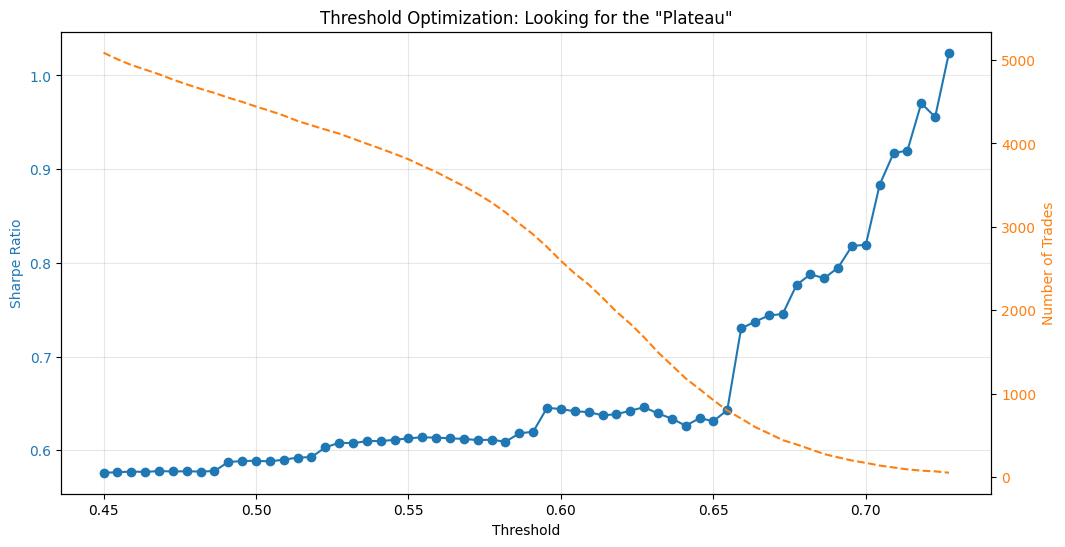

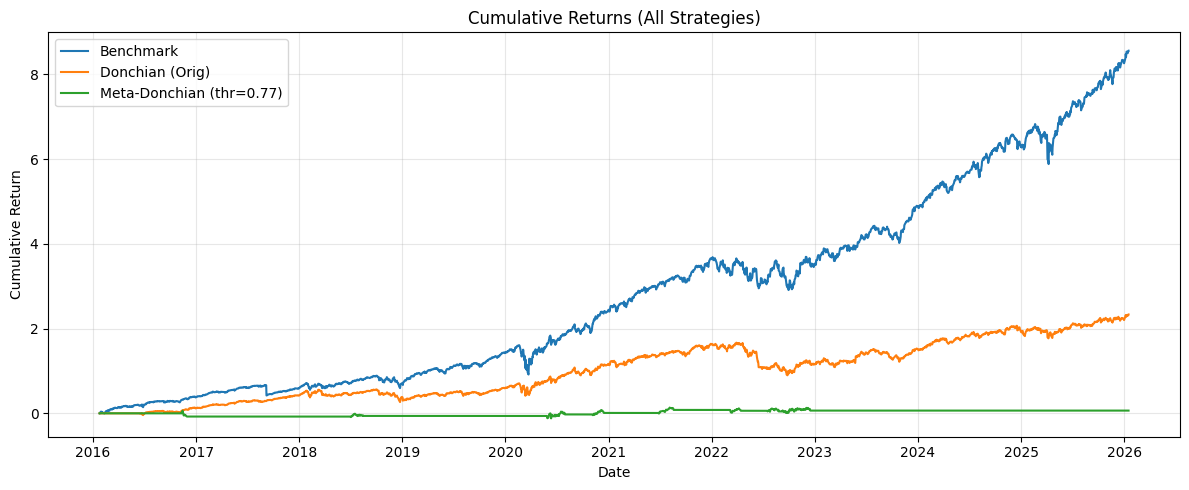

In [218]:
import matplotlib.pyplot as plt
import pandas as pd

series = {}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_thresholds(df, prob_col='meta_prob', ret_col='trade_ret', min_trades=50):
    # 1. Define range (e.g., 0.45 to 0.65). 
    # Don't go too high with RF/balanced weights; probabilities usually cluster near 0.5.
    thresholds = np.linspace(0.45, 0.9, 100) 
    results = []

    # 2. Iterate and simulate
    for t in thresholds:
        # Filter trades that pass the threshold
        subset = df[df[prob_col] >= t]
        
        n_trades = len(subset)
        if n_trades < min_trades:
            continue

        # Calculate metrics
        avg_ret = subset[ret_col].mean()
        win_rate = (subset[ret_col] > 0).mean()
        
        # Simple Sharpe (Per-trade, not annualized, but sufficient for comparison)
        std_ret = subset[ret_col].std()
        sharpe = avg_ret / std_ret if std_ret > 1e-6 else 0
        
        results.append({
            'Threshold': t,
            'Sharpe': sharpe,
            'Win Rate': win_rate,
            'Avg Return': avg_ret,
            'Trades': n_trades
        })

    return pd.DataFrame(results)

# Run the analysis
# Ensure 'cand' has the 'meta_prob' from the CV loop and your target 'trade_ret'
df_scan = analyze_thresholds(cand, prob_col='meta_prob', ret_col='trade_ret')

# 3. Visualization (Crucial for avoiding overfitting)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Sharpe (Blue)
color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Sharpe Ratio', color=color)
ax1.plot(df_scan['Threshold'], df_scan['Sharpe'], color=color, marker='o', label='Sharpe')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot Trade Count (Orange)
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Number of Trades', color=color)
ax2.plot(df_scan['Threshold'], df_scan['Trades'], color=color, linestyle='--', label='Count')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Threshold Optimization: Looking for the "Plateau"')
plt.show()


if "r_logic" in globals() and isinstance(r_logic, pd.Series) and len(r_logic) > 0:
    series["Donchian (Orig)"] = (1.0 + r_logic.fillna(0.0)).cumprod() - 1.0
elif "eq_logic" in globals() and isinstance(eq_logic, pd.Series) and len(eq_logic) > 0:
    series["Donchian (Orig)"] = (eq_logic / float(eq_logic.iloc[0])) - 1.0

if "r_meta" in globals() and isinstance(r_meta, pd.Series) and len(r_meta) > 0:
    series["Meta-Donchian"] = (1.0 + r_meta.fillna(0.0)).cumprod() - 1.0
elif "eq_meta" in globals() and isinstance(eq_meta, pd.Series) and len(eq_meta) > 0:
    series["Meta-Donchian"] = (eq_meta / float(eq_meta.iloc[0])) - 1.0

if "res_bh" in globals() and isinstance(res_bh, dict) and "returns" in res_bh and isinstance(res_bh["returns"], pd.Series) and len(res_bh["returns"]) > 0:
    r_bh = res_bh["returns"]
    series["Benchmark"] = (1.0 + r_bh.fillna(0.0)).cumprod() - 1.0
elif "eq_bh" in globals() and isinstance(eq_bh, pd.Series) and len(eq_bh) > 0:
    series["Benchmark"] = (eq_bh / float(eq_bh.iloc[0])) - 1.0

if not series:
    raise RuntimeError("No backtest return/equity series found. Run the backtest cell above first.")

cumrets = pd.concat(series, axis=1).sort_index().ffill().dropna(how="all")

plt.figure(figsize=(12, 5))
plt.plot(cumrets.index, cumrets["Benchmark"], label="Benchmark")
plt.plot(cumrets.index, cumrets["Donchian (Orig)"], label="Donchian (Orig)")
plt.plot(cumrets.index, cumrets["Meta-Donchian"], label=f"Meta-Donchian (thr={float(globals().get('THRESH', float('nan'))):.2f})")
plt.title("Cumulative Returns (All Strategies)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


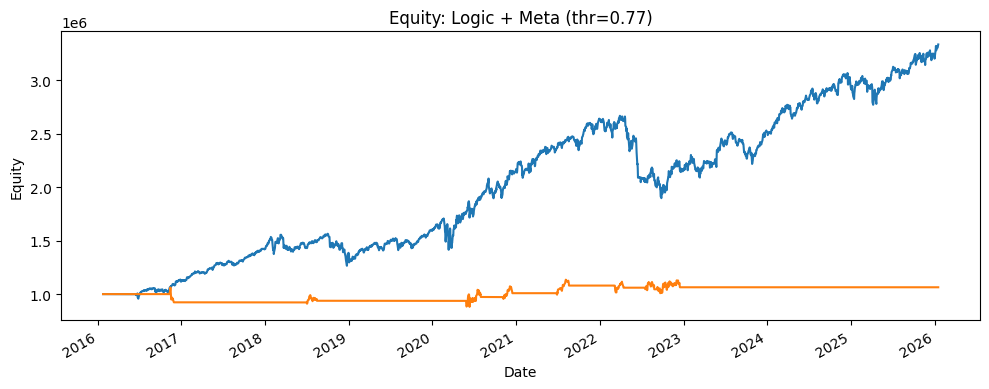

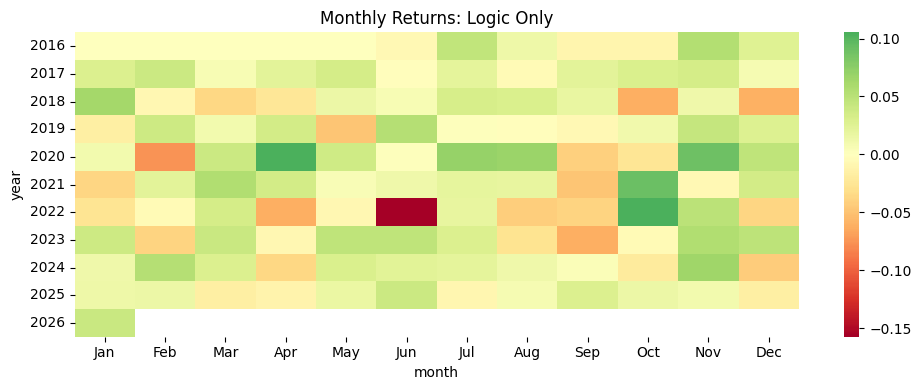

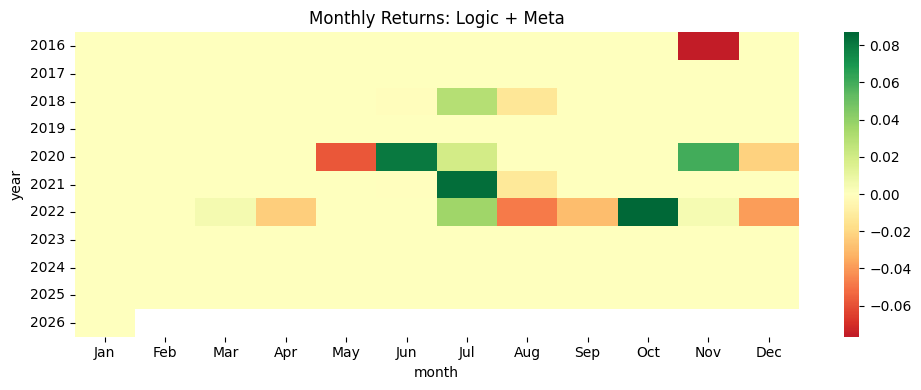

In [219]:
# Plots
plot_equity_curve(eq_logic, title='Equity: Logic Only')
plot_equity_curve(eq_meta, title=f'Equity: Logic + Meta (thr={THRESH})')
plot_monthly_heatmap(r_logic, title='Monthly Returns: Logic Only')
plot_monthly_heatmap(r_meta, title='Monthly Returns: Logic + Meta')

## 6) Diagnostics & Reporting

This section generates the **exact plots you’d typically include in a quant research report**:
- Feature health (correlation + importance + label balance)
- Strategy performance (equity + drawdown)
- Risk/statistics (rolling Sharpe/Sortino, return histogram, monthly heatmap)
- Meta-labeling diagnostics (precision–recall, threshold surface)
- Execution proxies (impact vs turnover) + entry/exit overlay

All figures are saved to `reports/figures/`.

In [220]:
# Ensure we are using the *current* implementation of at.viz.plots (avoid stale imports)
import importlib
import inspect

import at.viz.plots as _viz_plots

importlib.reload(_viz_plots)

print("plot_monthly_heatmap loaded from:", _viz_plots.__file__)
print("plot_monthly_heatmap signature:", inspect.signature(_viz_plots.plot_monthly_heatmap))


plot_monthly_heatmap loaded from: /home/manan/codes/precog/algorithmic-trading/src/at/viz/plots.py
plot_monthly_heatmap signature: (returns: 'pd.Series', title: 'str' = 'Monthly Returns', *, show_total: 'bool' = False, annot: 'bool' = False) -> 'None'


Saved: reports/figures/feature_correlation_heatmap.png


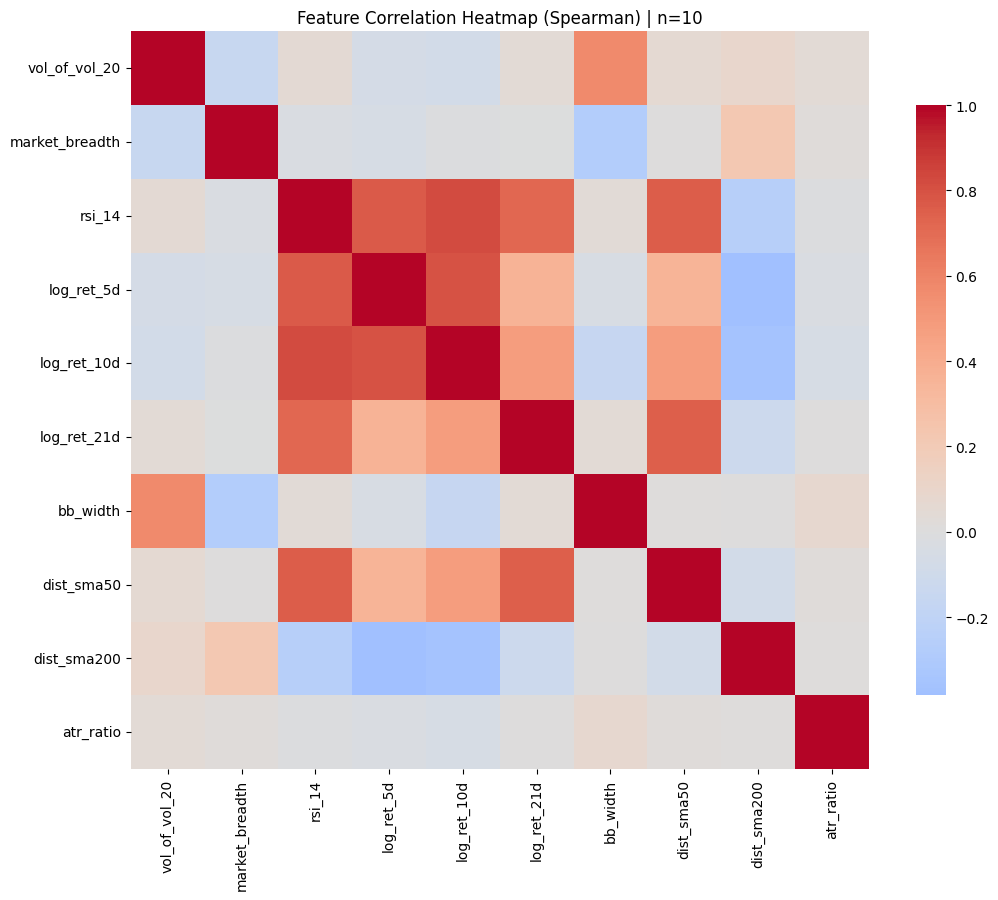

Saved: reports/figures/feature_importance_gini.png


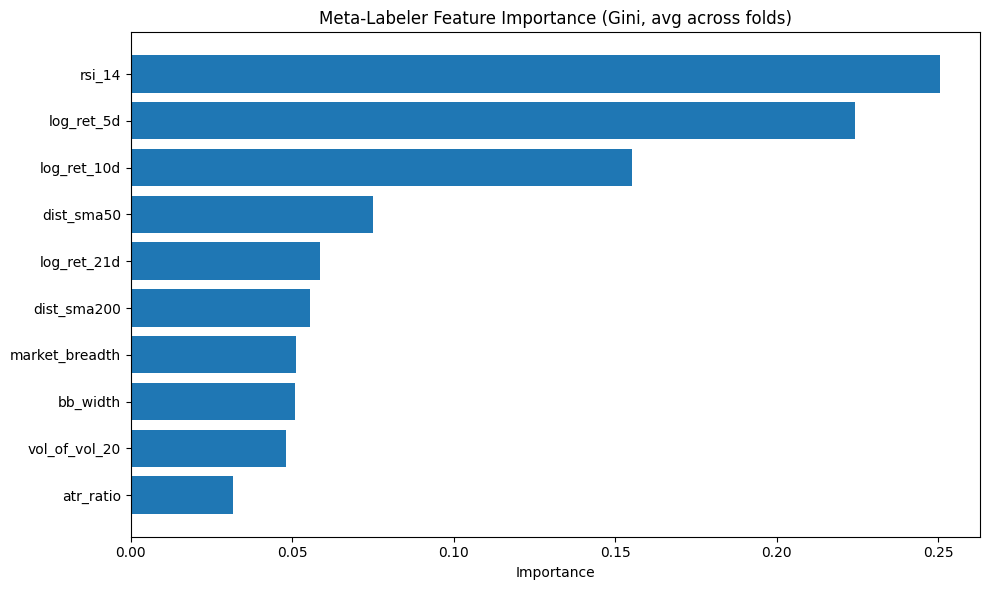

SHAP importance skipped: ValueError('Data must be 1-dimensional, got ndarray of shape (10, 2) instead')
Saved: reports/figures/target_distribution_meta_y.png


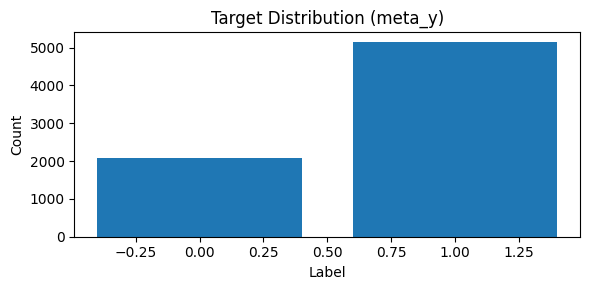

Saved: reports/figures/underwater_drawdown_compare.png


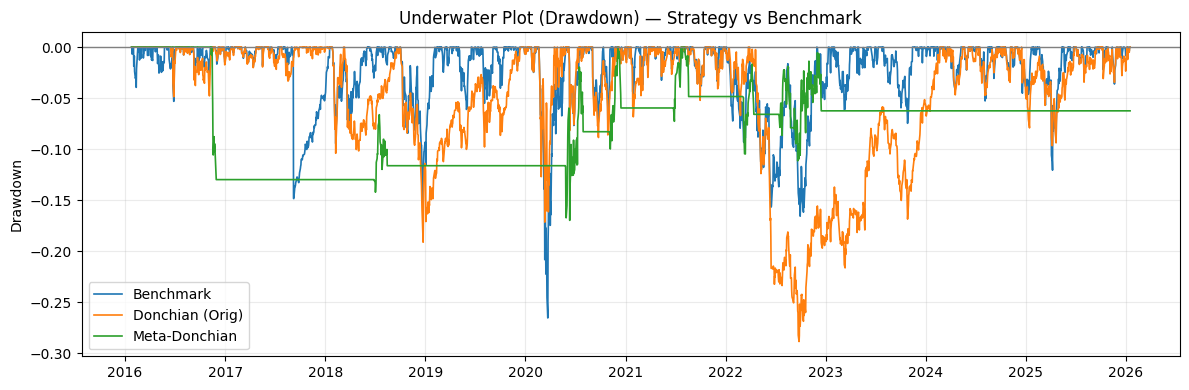

Saved: reports/figures/rolling_sharpe_63d.png


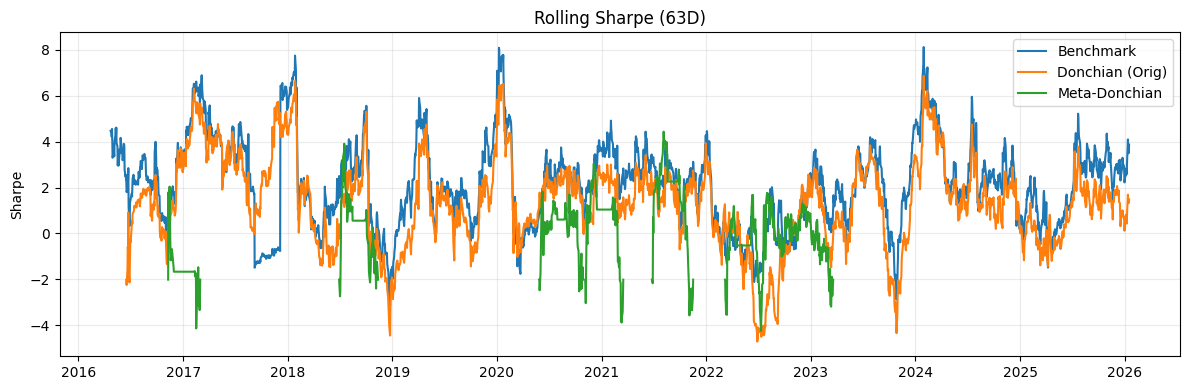

Saved: reports/figures/rolling_sortino_63d.png


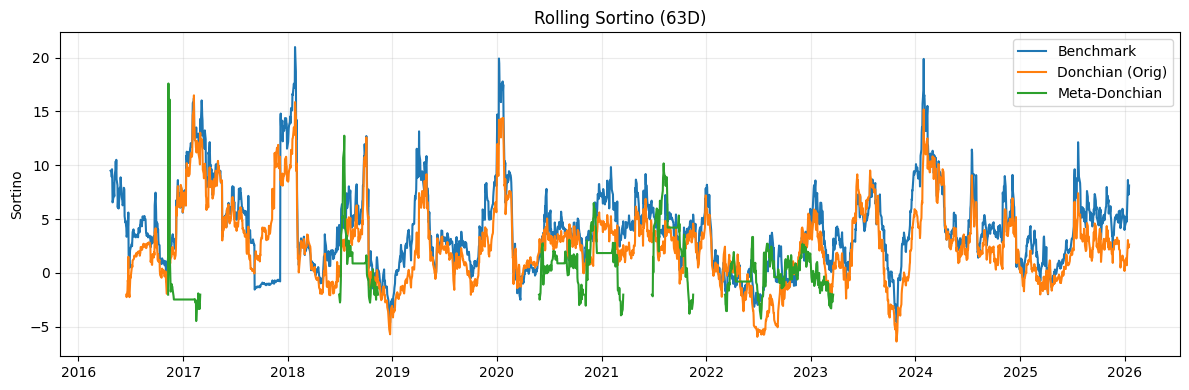

Saved: reports/figures/return_distribution_meta.png


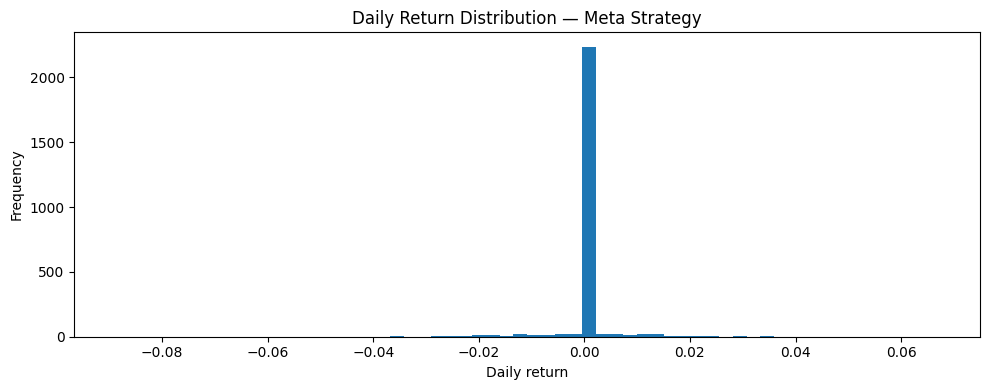

Saved: reports/figures/monthly_returns_logic.png


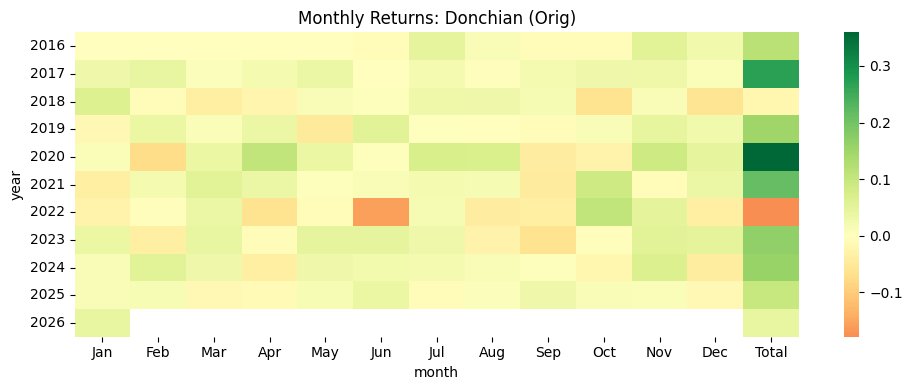

Saved: reports/figures/monthly_returns_meta.png


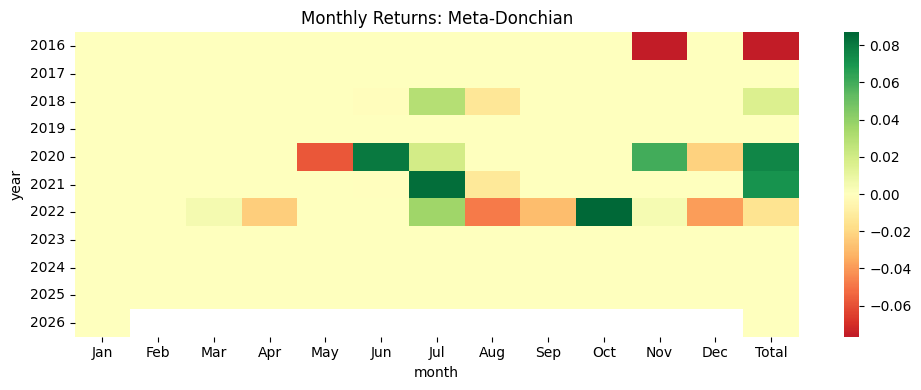

Saved: reports/figures/precision_recall_curve.png


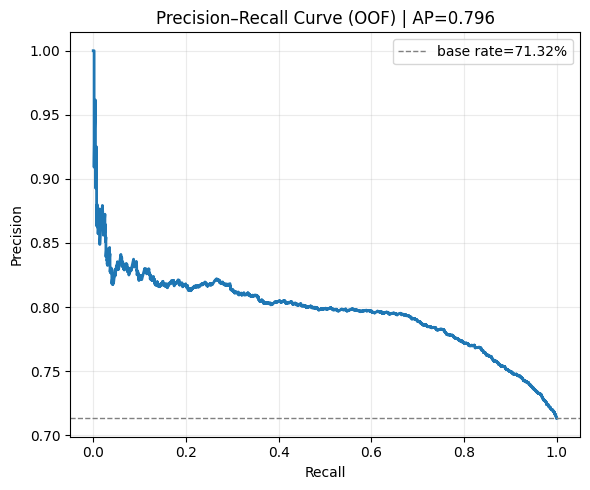

Saved: reports/figures/threshold_surface_sharpe.png


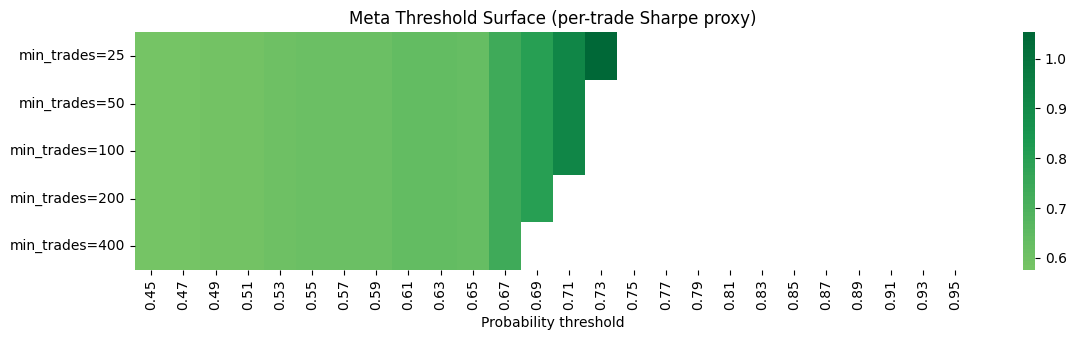

Saved: reports/figures/trade_entry_exit_candles.png


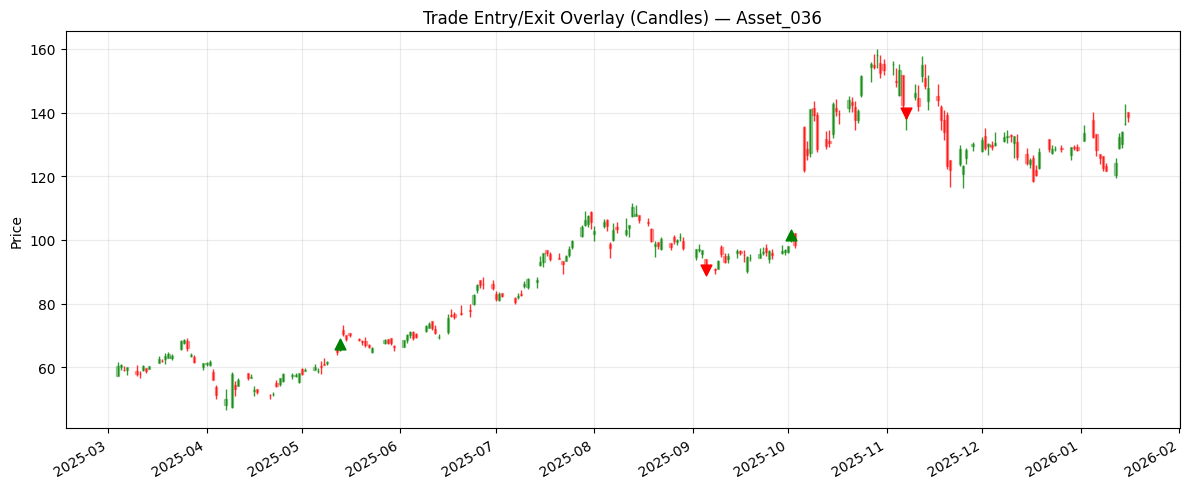

In [221]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_curve, average_precision_score

from at.viz.plots import plot_monthly_heatmap


fig_dir = Path("reports/figures")
fig_dir.mkdir(parents=True, exist_ok=True)


def _savefig(name: str) -> None:
    out = fig_dir / name
    plt.savefig(out, dpi=150, bbox_inches="tight")
    print(f"Saved: {out}")


def _get_feature_frame() -> pd.DataFrame:
    if "X" in globals() and isinstance(globals()["X"], pd.DataFrame):
        return globals()["X"]
    if "features" in globals() and isinstance(globals()["features"], pd.DataFrame):
        # fall back to numeric-only feature table if present
        return globals()["features"].select_dtypes(include=["number"]).copy()
    raise KeyError("No feature frame found (expected `X` or `features`).")


def _get_meta_event_frame() -> pd.DataFrame:
    if "cand" in globals() and isinstance(globals()["cand"], pd.DataFrame):
        return globals()["cand"]
    raise KeyError("No event frame found (expected `cand`).")


# -----------------------------
# 1) Feature health
# -----------------------------
X_feat = _get_feature_frame().copy()

# Correlation heatmap (Spearman; sample for speed)
max_rows = 5000
X_corr = X_feat
if len(X_corr) > max_rows:
    X_corr = X_corr.sample(max_rows, random_state=42)

corr = X_corr.corr(method="spearman").replace([np.inf, -np.inf], np.nan)

MAX_HEATMAP_FEATURES = 40
if corr.shape[0] > MAX_HEATMAP_FEATURES:
    # pick features that are most correlated with others (high average |corr|)
    score = corr.abs().sum(axis=0).sort_values(ascending=False)
    keep = score.index[:MAX_HEATMAP_FEATURES]
    corr = corr.loc[keep, keep]

plt.figure(figsize=(11, 9))
sns.heatmap(corr, cmap="coolwarm", center=0.0, square=True, cbar_kws={"shrink": 0.8})
plt.title(f"Feature Correlation Heatmap (Spearman) | n={corr.shape[0]}")
plt.tight_layout()
_savefig("feature_correlation_heatmap.png")
plt.show()


# Feature importance (Gini + SHAP if possible)
if "models" in globals() and isinstance(globals()["models"], list) and len(globals()["models"]) > 0:
    models = globals()["models"]
    fi_rows = []
    for m in models:
        if hasattr(m, "feature_importances_"):
            fi_rows.append(np.asarray(m.feature_importances_, dtype=float))

    if fi_rows:
        fi = pd.Series(np.nanmean(np.vstack(fi_rows), axis=0), index=X_feat.columns)
        fi = fi.sort_values(ascending=False)
        top = fi.head(25)[::-1]

        plt.figure(figsize=(10, 6))
        plt.barh(top.index, top.values)
        plt.title("Meta-Labeler Feature Importance (Gini, avg across folds)")
        plt.xlabel("Importance")
        plt.tight_layout()
        _savefig("feature_importance_gini.png")
        plt.show()

    # SHAP (sample; may be slower)
    try:
        import shap  # type: ignore

        model0 = models[0]
        X_shap = X_feat
        if len(X_shap) > 2000:
            X_shap = X_shap.sample(2000, random_state=42)

        explainer = shap.TreeExplainer(model0)
        shap_vals = explainer.shap_values(X_shap)
        if isinstance(shap_vals, list):
            sv = shap_vals[1] if len(shap_vals) > 1 else shap_vals[0]
        else:
            sv = shap_vals

        shap_imp = pd.Series(np.abs(np.asarray(sv)).mean(axis=0), index=X_feat.columns).sort_values(ascending=False)
        top = shap_imp.head(25)[::-1]

        plt.figure(figsize=(10, 6))
        plt.barh(top.index, top.values)
        plt.title("Meta-Labeler Feature Importance (SHAP | mean |value|)")
        plt.xlabel("mean(|SHAP|)")
        plt.tight_layout()
        _savefig("feature_importance_shap.png")
        plt.show()
    except Exception as e:
        print("SHAP importance skipped:", repr(e))

else:
    print("No trained meta models found (`models`). Run the CPCV training cell first.")


# Target distribution (meta labels)
cand_df = _get_meta_event_frame()

label_col = "meta_y" if "meta_y" in cand_df.columns else None
if label_col is None and "y" in globals():
    # y is a numpy array in this notebook; plot it as a fallback
    y_arr = np.asarray(globals()["y"])
    vals, cnts = np.unique(y_arr[~np.isnan(y_arr.astype(float))], return_counts=True)
    plt.figure(figsize=(6, 3))
    plt.bar(vals.astype(int), cnts)
    plt.title("Target Distribution (y)")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.tight_layout()
    _savefig("target_distribution_y.png")
    plt.show()
else:
    y_ser = cand_df[label_col].astype(float)
    counts = y_ser.value_counts(dropna=True).sort_index()
    plt.figure(figsize=(6, 3))
    plt.bar(counts.index.astype(int), counts.values)
    plt.title("Target Distribution (meta_y)")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.tight_layout()
    _savefig("target_distribution_meta_y.png")
    plt.show()


# -----------------------------
# 2) Strategy performance: equity + drawdown
# -----------------------------

def _drawdown_pct(eq: pd.Series) -> pd.Series:
    s = pd.Series(eq, dtype=float).copy()
    s.index = pd.to_datetime(s.index)
    s = s.sort_index()
    return (s / s.cummax()) - 1.0


def _plot_underwater_compare(series: dict[str, pd.Series], title: str) -> None:
    plt.figure(figsize=(12, 4))
    for name, eq in series.items():
        dd = _drawdown_pct(eq)
        plt.plot(dd.index, dd.values, label=name, linewidth=1.2)
    plt.axhline(0.0, color="gray", linewidth=1.0)
    plt.title(title)
    plt.ylabel("Drawdown")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()


eq_series = {}
if "eq_bh" in globals():
    eq_series["Benchmark"] = globals()["eq_bh"]
if "eq_logic" in globals():
    eq_series["Donchian (Orig)"] = globals()["eq_logic"]
if "eq_meta" in globals():
    eq_series["Meta-Donchian"] = globals()["eq_meta"]

if eq_series:
    _plot_underwater_compare(eq_series, "Underwater Plot (Drawdown) — Strategy vs Benchmark")
    _savefig("underwater_drawdown_compare.png")
    plt.show()
else:
    print("No equity series found. Run the backtest cell first.")


# -----------------------------
# 3) Risk & statistical metrics
# -----------------------------

def _rolling_sharpe(r: pd.Series, window: int = 63, ann: int = 252) -> pd.Series:
    s = pd.Series(r, dtype=float).copy()
    s.index = pd.to_datetime(s.index)
    s = s.sort_index().fillna(0.0)
    mu = s.rolling(window).mean()
    sd = s.rolling(window).std(ddof=0)
    return (mu / sd.replace(0, np.nan)) * np.sqrt(ann)


def _rolling_sortino(r: pd.Series, window: int = 63, ann: int = 252) -> pd.Series:
    s = pd.Series(r, dtype=float).copy()
    s.index = pd.to_datetime(s.index)
    s = s.sort_index().fillna(0.0)
    mu = s.rolling(window).mean()
    downside = s.clip(upper=0.0)
    dd = downside.rolling(window).std(ddof=0)
    return (mu / dd.replace(0, np.nan)) * np.sqrt(ann)


r_series = {}
if "r_bh" in globals():
    r_series["Benchmark"] = globals()["r_bh"]
elif "res_bh" in globals() and isinstance(globals()["res_bh"], dict) and "returns" in globals()["res_bh"]:
    r_series["Benchmark"] = globals()["res_bh"]["returns"]
if "r_logic" in globals():
    r_series["Donchian (Orig)"] = globals()["r_logic"]
if "r_meta" in globals():
    r_series["Meta-Donchian"] = globals()["r_meta"]

if r_series:
    plt.figure(figsize=(12, 4))
    for name, r in r_series.items():
        plt.plot(_rolling_sharpe(r).index, _rolling_sharpe(r).values, label=name)
    plt.title("Rolling Sharpe (63D)")
    plt.ylabel("Sharpe")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    _savefig("rolling_sharpe_63d.png")
    plt.show()

    plt.figure(figsize=(12, 4))
    for name, r in r_series.items():
        plt.plot(_rolling_sortino(r).index, _rolling_sortino(r).values, label=name)
    plt.title("Rolling Sortino (63D)")
    plt.ylabel("Sortino")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    _savefig("rolling_sortino_63d.png")
    plt.show()

    if "r_meta" in globals() and isinstance(globals()["r_meta"], pd.Series):
        rm = globals()["r_meta"].astype(float).dropna()
        plt.figure(figsize=(10, 4))
        plt.hist(rm.values, bins=60)
        plt.title("Daily Return Distribution — Meta Strategy")
        plt.xlabel("Daily return")
        plt.ylabel("Frequency")
        plt.tight_layout()
        _savefig("return_distribution_meta.png")
        plt.show()

    # Monthly returns heatmap (with totals)
    if "r_logic" in globals():
        plot_monthly_heatmap(globals()["r_logic"], title="Monthly Returns: Donchian (Orig)", show_total=True)
        _savefig("monthly_returns_logic.png")
        plt.show()

    if "r_meta" in globals():
        plot_monthly_heatmap(globals()["r_meta"], title="Monthly Returns: Meta-Donchian", show_total=True)
        _savefig("monthly_returns_meta.png")
        plt.show()

else:
    print("No returns series found. Run the backtest cell first.")


# -----------------------------
# 4) Meta-labeling diagnostics
# -----------------------------
if {"meta_prob", "meta_y"}.issubset(set(cand_df.columns)):
    m = cand_df[["meta_prob", "meta_y", "trade_ret"]].copy()
    m = m.dropna(subset=["meta_prob", "meta_y"])
    y_true = m["meta_y"].astype(int).to_numpy()
    y_score = m["meta_prob"].astype(float).to_numpy()

    prec, rec, thr = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    base = float(np.mean(y_true))

    plt.figure(figsize=(6, 5))
    plt.plot(rec, prec, linewidth=2.0)
    plt.axhline(base, color="gray", linestyle="--", linewidth=1.0, label=f"base rate={base:.2%}")
    plt.title(f"Precision–Recall Curve (OOF) | AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    _savefig("precision_recall_curve.png")
    plt.show()

    # Threshold surface: Sharpe as function of prob-threshold and min-trade-count
    thresholds = np.linspace(0.45, 0.95, 26)
    mins = [25, 50, 100, 200, 400]

    mat = np.full((len(mins), len(thresholds)), np.nan, dtype=float)
    for i, min_trades in enumerate(mins):
        for j, t in enumerate(thresholds):
            sub = m[m["meta_prob"] >= float(t)]
            if len(sub) < int(min_trades):
                continue
            r = sub["trade_ret"].astype(float)
            sd = float(r.std(ddof=0))
            mat[i, j] = float(r.mean() / sd) if sd > 1e-9 else np.nan

    plt.figure(figsize=(12, 3.5))
    sns.heatmap(
        pd.DataFrame(mat, index=[f"min_trades={x}" for x in mins], columns=[f"{t:.2f}" for t in thresholds]),
        cmap="RdYlGn",
        center=0.0,
    )
    plt.title("Meta Threshold Surface (per-trade Sharpe proxy)")
    plt.xlabel("Probability threshold")
    plt.ylabel("")
    plt.tight_layout()
    _savefig("threshold_surface_sharpe.png")
    plt.show()
else:
    print("Meta columns missing from `cand` (expected meta_prob/meta_y). Run the meta-labeling CV cell first.")


# Trade entry/exit overlay (candlestick) for the single-ticker demo section
if all(k in globals() for k in ["sdf", "trades_df", "sample_ticker"]):
    import matplotlib.dates as mdates
    from matplotlib.patches import Rectangle

    sdf = globals()["sdf"].copy()
    sdf["date"] = pd.to_datetime(sdf["date"])
    sdf = sdf.sort_values("date")

    # focus on recent window for readability
    sdf_win = sdf.tail(220).copy()
    sdf_win["dnum"] = mdates.date2num(sdf_win["date"].dt.to_pydatetime())

    fig, ax = plt.subplots(figsize=(12, 5))

    w = 0.7  # candle width in days
    for _, row in sdf_win.iterrows():
        o, h, l, c = float(row["open"]), float(row["high"]), float(row["low"]), float(row["close"])
        x = float(row["dnum"])
        color = "green" if c >= o else "red"
        ax.vlines(x, l, h, color=color, linewidth=1.0, alpha=0.8)
        rect = Rectangle((x - w / 2, min(o, c)), w, abs(c - o) + 1e-9, facecolor=color, edgecolor=color, alpha=0.35)
        ax.add_patch(rect)

    tdf = globals()["trades_df"].copy()
    if not tdf.empty:
        tdf["Entry Date"] = pd.to_datetime(tdf["Entry Date"])
        tdf["Exit Date"] = pd.to_datetime(tdf["Exit Date"])
        tdf = tdf.sort_values("Entry Date")

        for _, t in tdf.iterrows():
            ed, exd = t["Entry Date"], t["Exit Date"]
            if ed >= sdf_win["date"].min():
                ax.scatter(mdates.date2num(ed.to_pydatetime()), float(t["Entry Price"]), marker="^", s=60, color="green", zorder=5)
            if exd >= sdf_win["date"].min():
                ax.scatter(mdates.date2num(exd.to_pydatetime()), float(t["Exit Price"]), marker="v", s=60, color="red", zorder=5)

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.set_title(f"Trade Entry/Exit Overlay (Candles) — {globals()['sample_ticker']}")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.25)
    fig.autofmt_xdate()
    plt.tight_layout()
    _savefig("trade_entry_exit_candles.png")
    plt.show()
else:
    print("Candlestick trade overlay skipped (expected `sdf`, `trades_df`, `sample_ticker` from the demo section).")


##  Statistical Arbitrage

Baseline discovery:
- Find top correlated pairs (Spearman) on returns
- Then run cointegration tests on those candidates

In [222]:
prices = df.pivot(index='date', columns='ticker', values='close').sort_index()
pairs = top_correlated_pairs(prices, top_k=30, method='spearman', min_overlap=200)
pairs.head(10)

,a,b,corr
0,Asset_010,Asset_016,0.859918
1,Asset_014,Asset_028,0.849927
2,Asset_067,Asset_068,0.844370
3,Asset_028,Asset_078,0.825610
4,Asset_013,Asset_021,0.825416
5,Asset_043,Asset_074,0.821035
6,Asset_014,Asset_078,0.810178
7,Asset_020,Asset_052,0.809252
8,Asset_028,Asset_042,0.790623
9,Asset_028,Asset_068,0.782622


In [223]:
coint = cointegration_scan(prices, pairs, max_pairs=30)
coint.head(10)

,a,b,coint_pvalue,coint_stat,corr
0,Asset_010,Asset_016,0.001743,-4.405562,0.859918
1,Asset_051,Asset_100,0.010682,-3.876608,0.751589
2,Asset_028,Asset_083,0.026015,-3.578881,0.710047
3,Asset_031,Asset_039,0.028779,-3.542878,0.753519
4,Asset_020,Asset_052,0.138041,-2.892418,0.809252
5,Asset_017,Asset_098,0.347197,-2.353470,0.720397
6,Asset_013,Asset_021,0.351981,-2.343660,0.825416
7,Asset_028,Asset_068,0.395532,-2.256335,0.782622
8,Asset_028,Asset_042,0.476473,-2.099797,0.790623
9,Asset_021,Asset_094,0.478929,-2.095100,0.733822


### Asset_010 vs Asset_016 (spread + z-score)

This is the plot you can drop into the final report:
- Compute $\beta$ from prices (simple regression)
- Spread = Price010 − (β × Price016)
- Plot spread z-score (mean reversion signal)

beta: 0.35260871603773475
cointegration p-value: 0.0017432607134675922


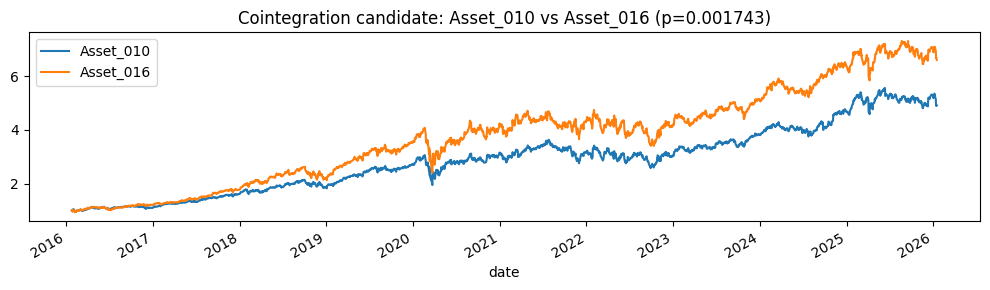

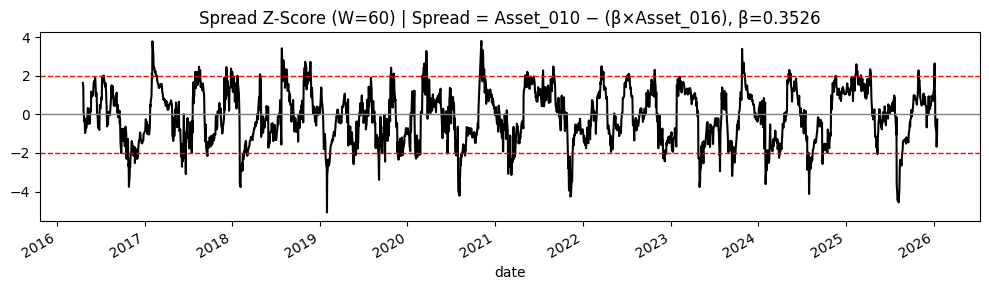

In [224]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint as eg_coint

t1, t2 = 'Asset_010', 'Asset_016'

if t1 not in prices.columns or t2 not in prices.columns:
    raise KeyError(f'Missing one of required tickers: {t1}, {t2}')

p1 = prices[t1].dropna()
p2 = prices[t2].dropna()
idx = p1.index.intersection(p2.index)
p1 = p1.loc[idx]
p2 = p2.loc[idx]

# Estimate beta (no intercept) for Spread = P1 - beta*P2
beta = float((p1 * p2).sum() / (p2 * p2).sum())
spread = p1 - beta * p2

# Cointegration p-value for the report claim
stat, pval, _ = eg_coint(p1, p2)
print('beta:', beta)
print('cointegration p-value:', float(pval))

# Z-score the spread
W = 60
mu = spread.rolling(W, min_periods=W).mean()
sd = spread.rolling(W, min_periods=W).std(ddof=0)
z = (spread - mu) / sd

# Price co-movement plot (normalized)
plt.figure(figsize=(10, 3))
(p1 / p1.iloc[0]).plot(label=t1)
(p2 / p2.iloc[0]).plot(label=t2)
plt.title(f'Cointegration candidate: {t1} vs {t2} (p={pval:.4g})')
plt.legend()
plt.tight_layout()
plt.show()

# Spread z-score plot
plt.figure(figsize=(10, 3))
z.plot(color='black')
plt.axhline(0.0, color='gray', linewidth=1)
plt.axhline(2.0, color='red', linestyle='--', linewidth=1)
plt.axhline(-2.0, color='red', linestyle='--', linewidth=1)
plt.title(f'Spread Z-Score (W={W}) | Spread = {t1} − (β×{t2}), β={beta:.4f}')
plt.tight_layout()
plt.show()